When we design an ODE system to do tracking etc. can we train a MLP to approximate this system such that it instantiates an RNN that have continuous attractor?
* Here we have an explicit form of the vector field, so can learn with MSE, converge fast. No need for diffusion loss, converge faster. 
* If we run the system as RNN, can we see the same thing? 

$$
\frac{dx}{dt}=-x+R(\psi)\cos\psi-\alpha y(t)\omega(t)+\beta\cos(\psi_{0}(t)-\theta_{0})\\
\frac{dy}{dt}=-y+R(\psi)\sin\psi+\alpha x(t)\omega(t)+\beta\sin(\psi_{0}(t)-\theta_{0})
$$
$$
\frac{dr}{dt}=-r+R(\psi)+\beta\cos(\psi_{0}(t)-\theta_{0}-\psi(t))\\
\frac{d\psi}{dt}=\alpha\omega(t)+\frac{\beta}{r}\sin(\psi_{0}(t)-\theta_{0}-\psi(t))
$$
$$
R(r,\psi)=R_{0}+r\varepsilon\cos(\psi-\phi_{0})\\
\alpha=\frac{1}{1+\sigma_{v}^{2}},\,\,\beta=\frac{h}{\sigma_{h}^{2}(\sigma_{v}^{-2}+1)}
$$

In [6]:
import sys
# get rid of '/n/home12/binxuwang/.local/lib/python3.10/site-packages' in sys.path
try:
    sys.path.remove('/n/home12/binxuwang/.local/lib/python3.10/site-packages')
except ValueError:
    pass
sys.path

['/n/home12/binxuwang/Github/DiffusionMemorization/notebooks',
 '/n/home12/binxuwang/.conda/envs/torch2/lib/python310.zip',
 '/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10',
 '/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/lib-dynload',
 '',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Github/model-rearing-workshop',
 '/n/home12/binxuwang/Github/circuit_toolkit',
 '/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages']

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt

## Star ODE without function approximation

In [198]:
# Define the function for the system of ODEs
def eps_star_euclid_odes(t, state, R0, phi0, eps, sigma_v, sigma_h, h, psi0_f, theta0, omega_f):
    """_summary_

    Args:
        t (_type_): time
        state (_type_): state vector, [x, y]
        R0 (_type_): Base radius of ring manifold
        phi0 (_type_): Phase of the bulge on purturbed ring manifold
        eps (_type_): Amplitude of the perturbation
        sigma_v (_type_): noise scale in velocity
        sigma_h (_type_): noise scale in head direction signal
        h (_type_): amplitude of head direction signal, scalar or function
        psi0_f (_type_): time-varying head direction signal
        theta0 (_type_): phase of the head direction signal (relative to some landmark)
        omega_f (_type_): time-varying angular velocity

    Returns:
        _type_: _description_
    """
    # Unpack variables
    x, y, = state
    r = np.sqrt(x**2 + y**2)
    psi = np.arctan2(y, x)
    # Compute parameters
    alpha = 1 / (1 + sigma_v**2)
    beta = 1 / (sigma_h**2 * (sigma_v**(-2) + 1))
    # R function
    R_psi = R0 + r * eps * np.cos(psi - phi0)
    # Define the ODEs
    if callable(h):
        h = h(t)
    dx_dt = -x + R_psi * np.cos(psi) - alpha * y * omega_f(t) + beta * h * np.cos(psi0_f(t) - theta0)
    dy_dt = -y + R_psi * np.sin(psi) + alpha * x * omega_f(t) + beta * h * np.sin(psi0_f(t) - theta0)    
    return [dx_dt, dy_dt]

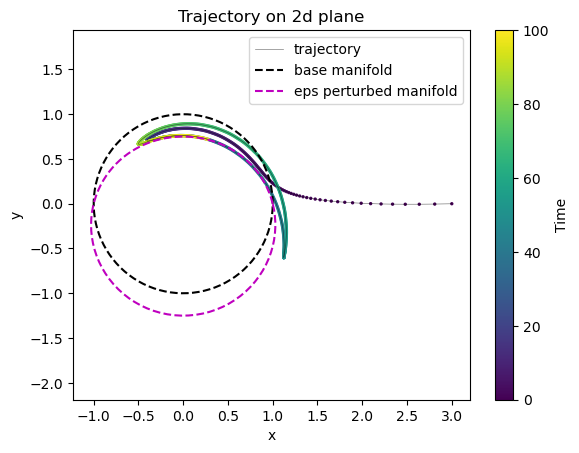

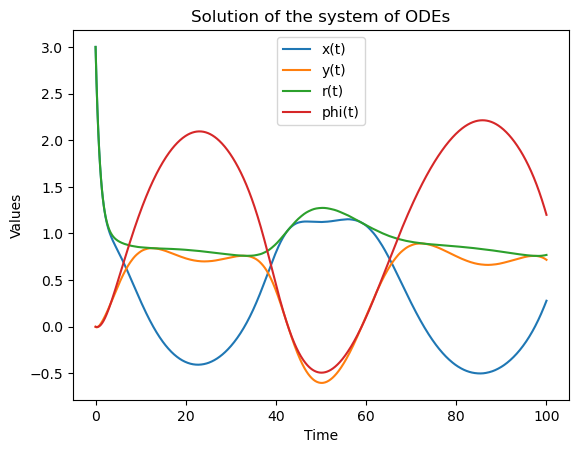

In [199]:
# Time span
t_span = (0, 100)  # From t=0 to t=10
t_eval = np.linspace(0, 100, 1000)  # Points at which to store the solution

# Speed, angular velocity, and head direction input signals
omega_fun = lambda t: -0.1
h_fun = lambda t: max(0, 0.1 * (1.5 + np.cos(0.1 * t)))
psi0_fun = lambda t: np.pi/2 + 0.1 * t #-0.2* t  # Example function for psi0
# Manifold Parameters
R0 = 1.0
eps = 0.25
phi0 = - np.pi/2
# Relative confidance in velocity and head direction signal, gating term of input. 
sigma_v = 0.1
sigma_h = 0.1
# h = 0.5
theta0 = 0.0 # this one is useless, can be combined into psi0
# Initial conditions
y0 = [3.0, 0.0,]  # Initial values for x, x_dot, r, psi
# Solve the system of ODEs
sol = solve_ivp(eps_star_euclid_odes, t_span, y0, t_eval=t_eval, 
                args=(R0, phi0, eps, sigma_v, sigma_h, h_fun, psi0_fun, theta0, omega_fun))

plt.figure()
# plot x, y on the 2d plane, colored by sol.t, add line connecting the points
plt.scatter(sol.y[0], sol.y[1], c=sol.t, lw=1, cmap='viridis', s=2, )
plt.plot(sol.y[0], sol.y[1], lw=0.5, c='k', alpha=0.5, label='trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Time')
# plot the unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(R0 *np.cos(theta), R0 *np.sin(theta), 'k--', label="base manifold")
plt.plot(R0 * (1 + eps * np.cos(theta - phi0)) * np.cos(theta),
         R0 * (1 + eps * np.cos(theta - phi0)) * np.sin(theta), 
        'm--', label="eps perturbed manifold")
plt.axis('equal')
plt.title('Trajectory on 2d plane')
plt.legend()
plt.show()

plt.figure()
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.plot(sol.t, sol.y[1], label='y(t)')
# compute r, phi
r = np.sqrt(sol.y[0]**2 + sol.y[1]**2)
phi = np.arctan2(sol.y[1], sol.y[0])
plt.plot(sol.t, r, label='r(t)')
plt.plot(sol.t, phi, label='phi(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Solution of the system of ODEs')
plt.show()

In [200]:
import numpy as np
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt

def normalize_angle(angle):
    # Use modulo operation to normalize the angle within -pi to pi range directly
    return (angle + math.pi) #(2 * math.pi) - math.pi


def plot_trajectory_on_2d_plane(omega_fun, h_fun, psi0_fun, theta0=0.0, 
                                R0=1.0, eps=0.0, phi0=np.pi / 2, 
                                sigma_v=0.1, sigma_h=0.1, 
                                y0=np.array([2.0, 0.0]),
                                t_span=[0, 100], 
                                t_eval=np.linspace(0, 100, 1000)):
    def eps_star_euclid_odes(t, state, R0, phi0, eps, sigma_v, sigma_h, h_fun, psi0_fun, theta0, omega_fun):
        x, y = state
        r = np.sqrt(x**2 + y**2)
        psi = np.arctan2(y, x)
        alpha = 1 / (1 + sigma_v**2)
        beta = 1 / (sigma_h**2 * (sigma_v**(-2) + 1))
        R_psi = R0 + r * eps * np.cos(psi - phi0)
        if callable(h_fun):
            h = h_fun(t)
        dx_dt = -x + R_psi * np.cos(psi) - alpha * y * omega_fun(t) + beta * h * np.cos(psi0_fun(t) - theta0)
        dy_dt = -y + R_psi * np.sin(psi) + alpha * x * omega_fun(t) + beta * h * np.sin(psi0_fun(t) - theta0)    
        return [dx_dt, dy_dt]

    sol = solve_ivp(eps_star_euclid_odes, t_span, y0, t_eval=t_eval, 
                    args=(R0, phi0, eps, sigma_v, sigma_h, h_fun, psi0_fun, theta0, omega_fun))

    r = np.sqrt(sol.y[0]**2 + sol.y[1]**2)
    phi = np.arctan2(sol.y[1], sol.y[0])
    # plot the trajectory on 2d plane
    plt.figure()
    plt.scatter(sol.y[0], sol.y[1], c=sol.t, lw=1, cmap='viridis', s=2)
    plt.plot(sol.y[0], sol.y[1], lw=0.5, c='k', alpha=0.5, label='trajectory')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(label='Time')
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(R0 *np.cos(theta), R0 *np.sin(theta), 'k--', label="base manifold")
    plt.plot(R0 * (1 + eps * np.cos(theta - phi0)) * np.cos(theta),
             R0 * (1 + eps * np.cos(theta - phi0)) * np.sin(theta), 
            'm--', label="eps perturbed manifold")
    plt.axis('equal')
    plt.title('Trajectory on 2d plane')
    plt.legend()
    plt.show()
    # plot the 2d head direction signal and angular velocity
    h_vec = np.array([h_fun(t) for t in sol.t])
    psi0_vec = np.array([psi0_fun(t) for t in sol.t])
    omega_vec = np.array([omega_fun(t) for t in sol.t])
    omege_cumsum = np.cumsum(omega_vec) * (sol.t[1] - sol.t[0]) + phi[0]
    plt.figure()
    plt.scatter(h_vec * np.cos(psi0_vec), h_vec * np.sin(psi0_vec), c=sol.t, lw=1, cmap='viridis', s=2, 
                label='2d head direction signal')
    plt.plot(h_vec * np.cos(psi0_vec), h_vec * np.sin(psi0_vec), lw=0.5, c='k', alpha=0.5)
    plt.scatter(np.cos(omege_cumsum), np.sin(omege_cumsum), c=sol.t, lw=1, cmap='viridis', s=2, 
                label='angular velocity integration')
    plt.plot(np.cos(omege_cumsum), np.sin(omege_cumsum), lw=0.5, c='k', alpha=0.5)
    plt.legend()
    plt.axis('equal')
    plt.title('2d head direction signal and angular velocity integration')
    plt.show()
    # plot input signals as time sequence
    plt.figure(figsize=(8, 4.5))
    plt.plot(sol.t, h_vec, label='h(t)')
    plt.plot(sol.t, normalize_angle(psi0_vec), label='psi0(t)')
    plt.plot(sol.t, omega_vec, label='omega(t)')
    plt.plot(sol.t, normalize_angle(omege_cumsum), label='\Int omega(t)')
    plt.xlabel('Time')
    plt.ylabel('Input signals')
    plt.legend() 
    plt.title('Input signals')
    plt.show()
    # plot the solution as time sequence
    plt.figure(figsize=(8, 4.5))
    plt.plot(sol.t, sol.y[0], label='x(t)')
    plt.plot(sol.t, sol.y[1], label='y(t)')
    plt.plot(sol.t, r, label='r(t)')
    plt.plot(sol.t, phi, label='phi(t)')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Solution of the system of ODEs')
    plt.show()
    

Tracking head direction signal with varying confidence level

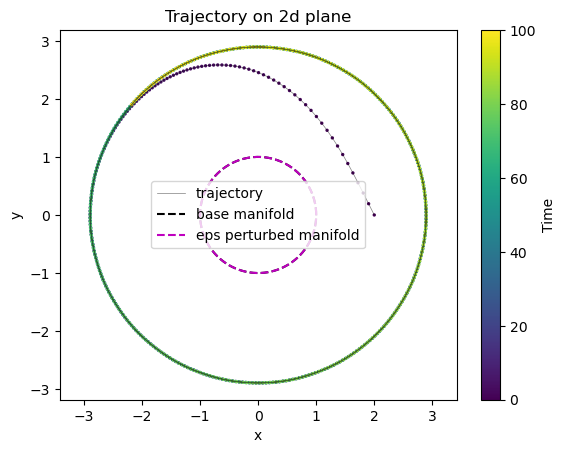

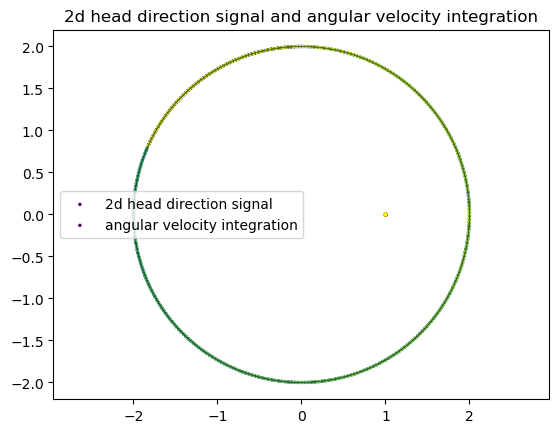

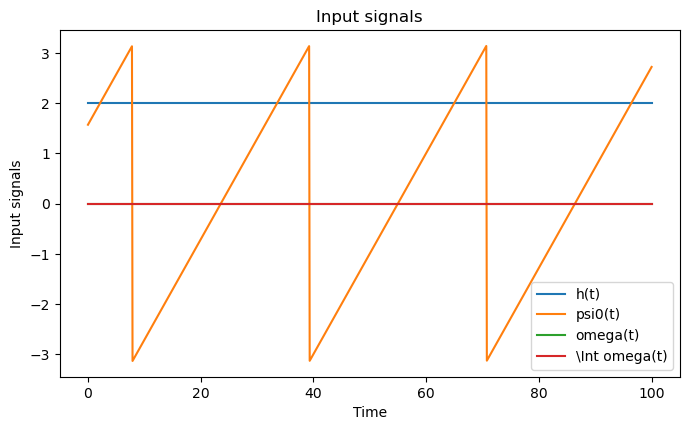

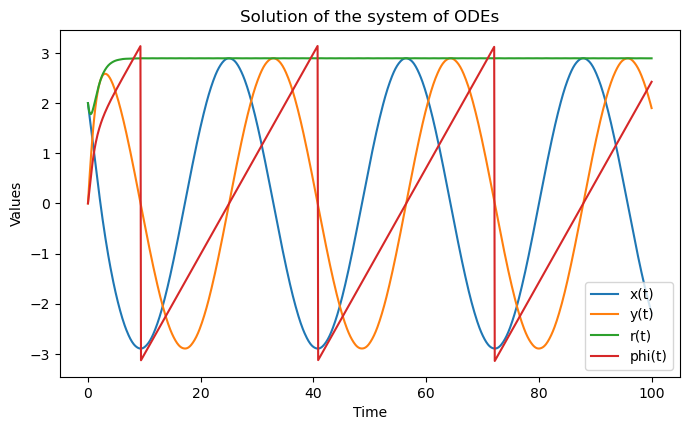

In [201]:
omega_fun = lambda t: 0.0
h_fun = lambda t: 2#np.clip(1 * (1.1 + np.cos(0.1 * t)), 0.0, None)
psi0_fun = lambda t: np.pi/2 + 0.2 * t #-0.2* t  # Example function for psi0
plot_trajectory_on_2d_plane(omega_fun, h_fun, psi0_fun, eps=0.0)

### Conflicting cue experiments

When velocity and head direction cue have conflicting speed 

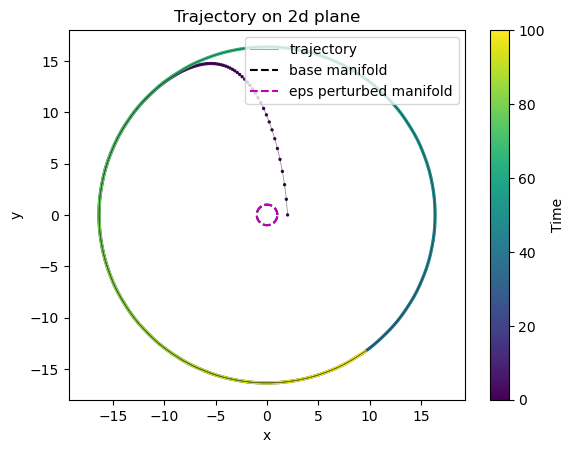

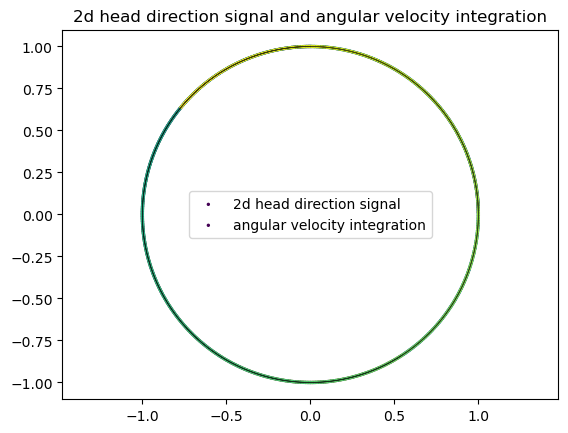

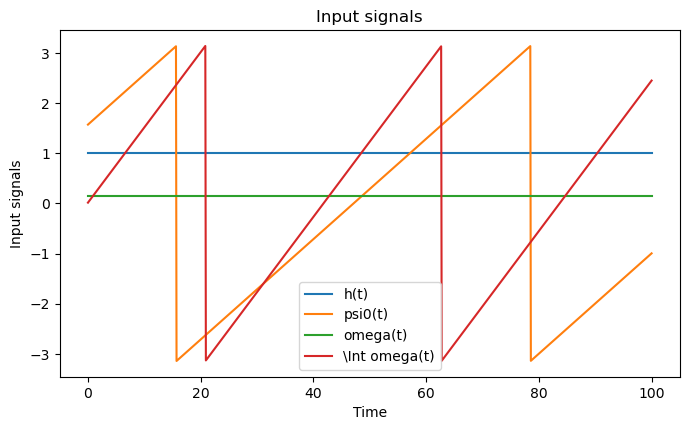

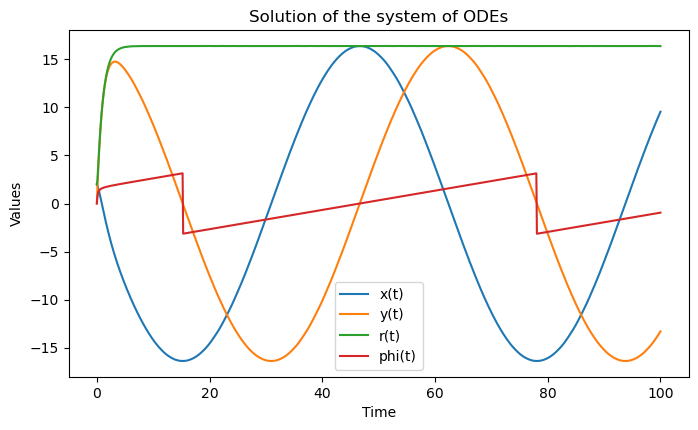

In [202]:
omega_fun = lambda t: 0.15
h_fun = lambda t: 1 #np.clip(1 * (1.1 + np.cos(0.1 * t)), 0.0, None)
psi0_fun = lambda t: np.pi/2 + 0.1 * t #-0.2* t  # Example function for psi0
plot_trajectory_on_2d_plane(omega_fun, h_fun, psi0_fun, eps=0.0, sigma_v=0.2, sigma_h=0.05)

## Star ODE with Function approximation system

### Utils for plotting

In [8]:
import math
def normalize_angle(angle):
    # Use modulo operation to normalize the angle within -pi to pi range directly
    return (angle + math.pi) #(2 * math.pi) - math.pi

### Learning

In [9]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm, trange
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Obtain Training and target function

In [20]:
def target_function(x, y, omega, x0, y0, Hx, Hy, 
                    sigma_v=1.0, sigma_h=1.0, R0=1.0, ):
    """ Target function for the ODE system 
    Input
      x, y
      omega
      x0, y0
      Hx, Hy 
    Output
      dx, dy
    """
    alpha = 1 / (1 + sigma_v**2)
    beta  = 1 / (sigma_h**2 * (sigma_v**(-2) + 1))
    R_f = R0 + x0 * x + y0 * y
    r = np.sqrt(x**2 + y**2)
    dx = -x + R_f * x / r - alpha * y * omega + Hx
    dy = -y + R_f * y / r + alpha * x * omega + Hy
    return dx, dy
  
  
def construct_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, **kwargs):
    np.random.seed(0)
    
    x = np.random.randn(n_samples)
    y = np.random.randn(n_samples)
    omega = np.random.uniform(omega_lim[0], omega_lim[1], n_samples)
    x0 = np.random.randn(n_samples) * x0norm
    y0 = np.random.randn(n_samples) * x0norm
    Hx = np.random.randn(n_samples) * 0.1
    Hy = np.random.randn(n_samples) * 0.1
    
    target_dx, target_dy = target_function(x, y, omega, x0, y0, Hx, Hy, **kwargs)
    
    assert target_dx.shape == target_dy.shape == x.shape == y.shape == omega.shape == x0.shape == y0.shape == Hx.shape == Hy.shape
    
    return x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy


def construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, **kwargs):
    x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy = construct_dataset(n_samples, omega_lim, x0norm, **kwargs)
    dataset = TensorDataset(torch.tensor(np.stack([x, y, omega, x0, y0, Hx, Hy], axis=1), dtype=torch.float32),
                        torch.tensor(np.stack([target_dx, target_dy], axis=1), dtype=torch.float32))
    return dataset

### Build and train function approximator

In [18]:
def build_randfeature_MLP(n_width, n_depth, activation=nn.ReLU,
              input_dim=7, output_dim=2):
    layers = []
    layers.append(nn.Linear(input_dim, n_width))
    layers.append(nn.ReLU())
    for i in range(n_depth-1):
        layers.append(nn.Linear(n_width, n_width))
        layers.append(activation())
    layers.append(nn.Linear(n_width, output_dim))
    model = nn.Sequential(*layers)
    model[0].weight.requires_grad = False
    model[0].bias.requires_grad = False
    return model


def build_MLP(n_width, n_depth, activation=nn.ReLU,
              input_dim=7, output_dim=2):
    layers = []
    layers.append(nn.Linear(input_dim, n_width))
    layers.append(nn.ReLU())
    for i in range(n_depth-1):
        layers.append(nn.Linear(n_width, n_width))
        layers.append(activation())
    layers.append(nn.Linear(n_width, output_dim))
    model = nn.Sequential(*layers)
    return model

In [19]:
def train_MLP(dataset, model=None, n_depth=1, n_width=128, 
              lr=1e-3, n_epochs=10000, print_every=500):
    # n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, R0=1.0, sigma_v=0.1, sigma_h=0.1
    # Construct dataset
    if dataset is None:
        n_samples = 10000
        omega_lim = (-0.2, 0.2)
        x0norm = 0.1
        R0 = 1.0
        sigma_v = 0.1
        sigma_h = 0.1
        dataset = construct_torch_dataset(n_samples=n_samples, omega_lim=omega_lim, x0norm=x0norm,
                                      R0=R0, sigma_v=sigma_v, sigma_h=sigma_h)
    
    # Build model
    if model is None:
        model = build_MLP(n_width, n_depth)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = F.mse_loss
    
    # Prepare for training
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    x_batch, y_batch = dataset.tensors
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    model.to(device)
    model.train()
    
    # Training loop
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:    
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})
        if epoch #print_every == 0 or (epoch == 0) or (epoch == n_epochs-1):
            print(f'epoch {epoch}, loss: {loss.item()}')
    
    return model

### Non functional version

In [13]:
# sample dataset 
np.random.seed(0)
n_samples = 10000

x = np.random.randn(n_samples)
y = np.random.randn(n_samples)
omega_lim = [-0.2,0.2]
omega = np.random.uniform(omega_lim[0], omega_lim[1], n_samples)
x0norm = 0.1
x0 = np.random.randn(n_samples) * x0norm
y0 = np.random.randn(n_samples) * x0norm
Hx = np.random.randn(n_samples) * 0.1
Hy = np.random.randn(n_samples) * 0.1
target_dx, target_dy = target_function(x, y, omega, x0, y0, Hx, Hy)
# train a multi layer perceptron to predict dx, dy
assert target_dx.shape == target_dy.shape

In [11]:
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, R0=1.0, sigma_v=0.1, sigma_h=0.1)
# make a torch dataset of these, and train a MLP to predict dx, dy
model = build_MLP(64, 1)

In [ ]:
# optimize model
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1,
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
# make a torch dataset of these, and train a MLP to predict dx, dy
n_depth, n_width = 1, 128
model = build_MLP(n_width, n_depth)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = F.mse_loss
n_epochs = 10000
# use full batch update 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_batch, y_batch = dataset.tensors
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)
model.to(device)
model.train()
pbar = tqdm(range(n_epochs))
for epoch in pbar:    
    optimizer.zero_grad()
    y_pred = model(x_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    pbar.set_postfix({'loss': loss.item()})
    if epoch #500 == 0 or (epoch == 0):
        print(f'epoch {epoch}, loss: {loss.item()}')

### Train Normal MLP to conduct integration

In [14]:
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, 
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
n_depth, n_width = 1, 512
model = train_MLP(dataset, model=None, n_depth=n_depth, n_width=n_width, 
          lr=1e-3, n_epochs=10000, print_every=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.2466307431459427
epoch 1000, loss: 0.0022540639620274305
epoch 2000, loss: 0.0011046217987313867
epoch 3000, loss: 0.0007972899475134909
epoch 4000, loss: 0.0005722549394704401
epoch 5000, loss: 0.0004647413152270019
epoch 6000, loss: 0.0003966024669352919
epoch 7000, loss: 0.00035219258279539645
epoch 8000, loss: 0.0004969612346030772
epoch 9000, loss: 0.0004175706999376416
epoch 9999, loss: 0.00027597075677476823


Desired manifold 
$$
r(\phi)=\frac{R_0}{1-x_0\cos\phi-y_0\sin\phi}
$$

In [16]:
from torchdiffeq import odeint
def solve_neural_ode(model, ctrl_inps, y0, t_eval):
    @torch.no_grad()
    def ode_function(t, xy, ):
        dx_dy = model(torch.concat([xy, ctrl_inps(t)]))
        return dx_dy
    return odeint(lambda t, xy: ode_function(t, xy,), y0, t_eval, )#.cpu()

def plot_x_trajectory(sol, t_eval, expstr, R0=1, ring_x0=0.1, ring_y0=0.1):
    plt.figure()
    plt.plot(sol[:, 0], sol[:, 1])
    plt.scatter(sol[:, 0], sol[:, 1], c=t_eval, s=12, cmap='viridis', alpha=0.5)
    
    theta = np.linspace(0, 2*np.pi, 100)
    # target perturbed manifold
    R_f = R0 / (1 - ring_x0 * np.cos(theta) - ring_y0 * np.sin(theta))
    plt.plot(R0 * np.cos(theta), R0 * np.sin(theta), 'k--')
    plt.plot(R_f * np.cos(theta), R_f * np.sin(theta), 'm--', label="perturbed manifold")

    plt.axis('equal')
    plt.title(f'Trajectory on 2d plane\n{expstr}')
    plt.show()

def plot_solution_curve(sol, t_eval, ctrl_inps, expstr, sigma_v=0.1):
    r = torch.sqrt(sol[:, 0]**2 + sol[:, 1]**2)
    phi = torch.atan2(sol[:, 1], sol[:, 0])
    
    omega_t = torch.tensor([ctrl_inps(t)[0] for t in t_eval], dtype=torch.float32) * 1 / (1 + sigma_v**2)
    omega_int = torch.cumsum(omega_t, dim=0) * (t_eval[1] - t_eval[0]) + phi[0]

    plt.figure()
    plt.plot(t_eval, r, label='r(t)')
    plt.plot(t_eval, phi, label='phi(t)')
    plt.plot(t_eval, omega_t, label='omega(t)')
    plt.plot(t_eval, normalize_angle(omega_int), label='int omega(t)')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f'Solution of the system of ODEs\n{expstr}')
    plt.show()

In [27]:
sigma_v = 0.1

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

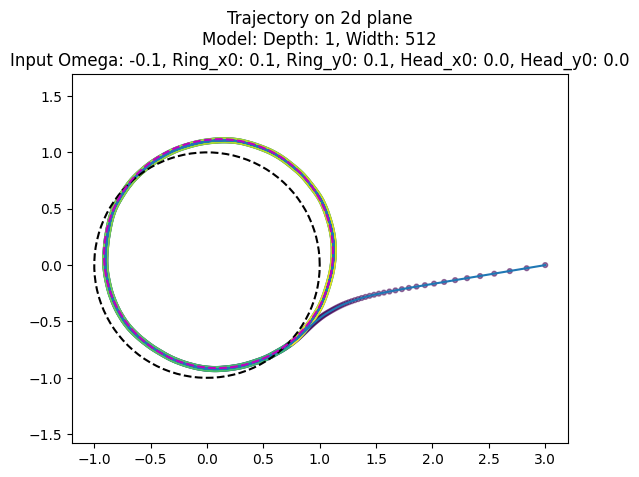

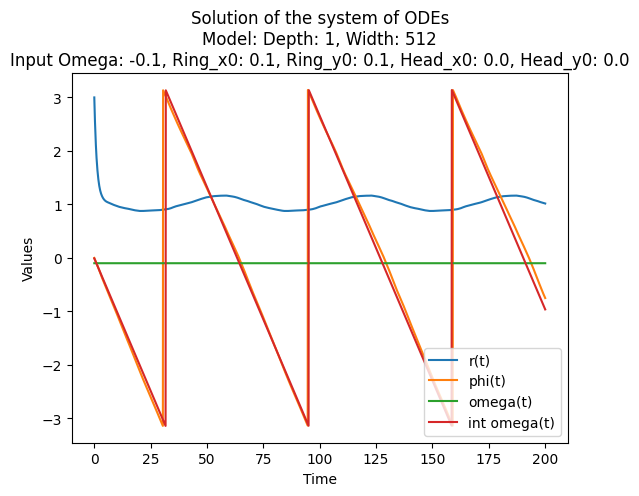

In [26]:
# solve the ode with torch model
t_span = (0, 200)
t_eval = torch.linspace(*t_span, 2000)
R0 = 1.0
omega0 = -0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
y0 = torch.tensor([3.0, 0.0], dtype=torch.float32, device=device)
sol = solve_neural_ode(model, ctrl_inps, y0, t_eval).cpu()
expstr = f'Model: Depth: {n_depth}, Width: {n_width}\nInput Omega: {omega0}, Ring_x0: {ring_x0}, Ring_y0: {ring_y0}, Head_x0: {H_x0}, Head_y0: {H_y0}'

plot_x_trajectory(sol, t_eval, expstr, R0, ring_x0, ring_y0)
plot_solution_curve(sol, t_eval, ctrl_inps, expstr, sigma_v=sigma_v)

### Look inside the two layer MLP model

In [ ]:
model

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=2, bias=True)
)

torch.Size([128, 7]) torch.Size([2, 128])


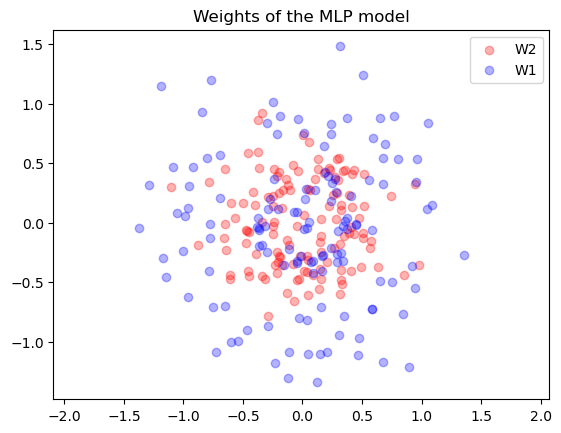

In [ ]:
W2 = model[-1].weight.detach().cpu()
W1 = model[0].weight.detach().cpu()
print(W1.shape, W2.shape)
plt.scatter(W2[0, :], W2[1, :], c='r', label='W2',alpha=0.3)
plt.scatter(W1[:, 0], W1[:, 1], c='b', label='W1',alpha=0.3)
plt.legend()
plt.title('Weights of the MLP model')
plt.axis('equal')
plt.show()


In [ ]:
def plot_weight_heatmap(W, title='Weight Heatmap'):
    sns.heatmap(W, cmap='coolwarm', center=0)
    plt.title(title)
    plt.axis('image')
    plt.tight_layout()
    plt.show()
    

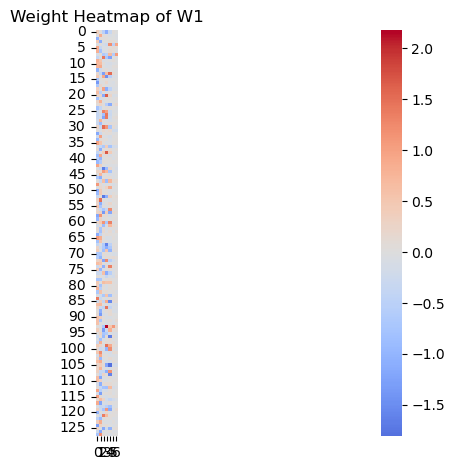

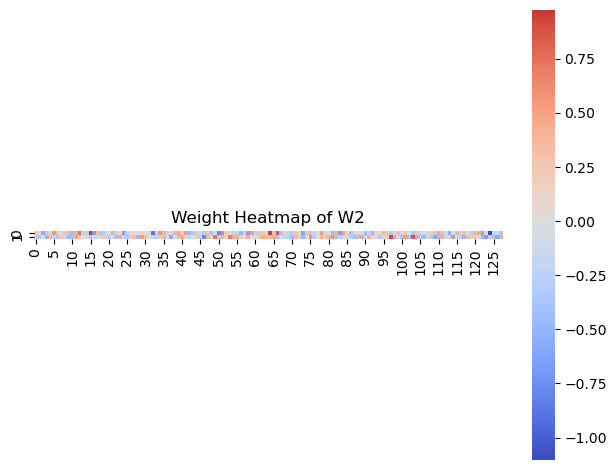

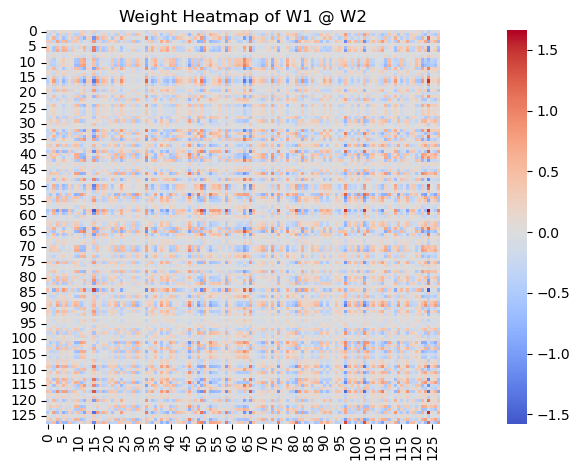

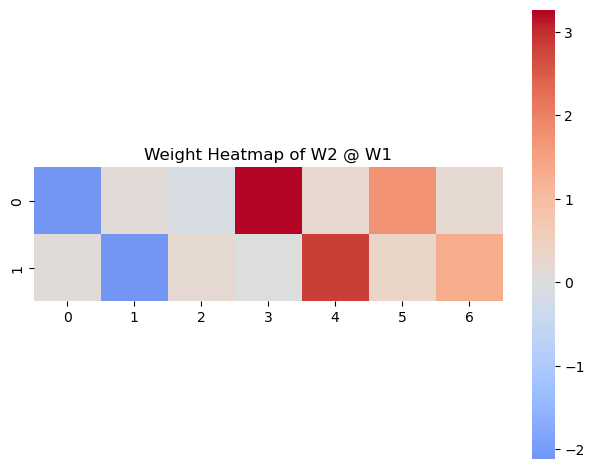

In [ ]:
plot_weight_heatmap(W1, title='Weight Heatmap of W1')
plot_weight_heatmap(W2, title='Weight Heatmap of W2')
plot_weight_heatmap(W1[:, :2] @ W2, title='Weight Heatmap of W1 @ W2')
plot_weight_heatmap(W2 @ W1, title='Weight Heatmap of W2 @ W1')

## Running MLP in RNN mode

In [21]:
def target_function(x, y, omega, x0, y0, Hx, Hy, 
                    sigma_v=1.0, sigma_h=1.0, R0=1.0, ):
    """ Target function for the ODE system 
    Input
      x, y
      omega
      x0, y0
      Hx, Hy 
    Output
      dx, dy
    """
    alpha = 1 / (1 + sigma_v**2)
    beta  = 1 / (sigma_h**2 * (sigma_v**(-2) + 1))
    R_f = R0 + x0 * x + y0 * y
    r = np.sqrt(x**2 + y**2)
    dx = -x + R_f * x / r - alpha * y * omega + Hx
    dy = -y + R_f * y / r + alpha * x * omega + Hy
    return dx + x, dy + y

In [22]:
def construct_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, **kwargs):
    np.random.seed(0)
    
    x = np.random.randn(n_samples)
    y = np.random.randn(n_samples)
    omega = np.random.uniform(omega_lim[0], omega_lim[1], n_samples)
    x0 = np.random.randn(n_samples) * x0norm
    y0 = np.random.randn(n_samples) * x0norm
    Hx = np.random.randn(n_samples) * 0.1
    Hy = np.random.randn(n_samples) * 0.1
    
    target_dx, target_dy = target_function(x, y, omega, x0, y0, Hx, Hy, **kwargs)
    
    assert target_dx.shape == target_dy.shape == x.shape == y.shape == omega.shape == x0.shape == y0.shape == Hx.shape == Hy.shape
    
    return x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy


def construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, **kwargs):
    x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy = construct_dataset(n_samples, omega_lim, x0norm, **kwargs)
    dataset = TensorDataset(torch.tensor(np.stack([x, y, omega, x0, y0, Hx, Hy], axis=1), dtype=torch.float32),
                        torch.tensor(np.stack([target_dx, target_dy], axis=1), dtype=torch.float32))
    return dataset

In [23]:
from torchdiffeq import odeint
def solve_neural_ode(model, ctrl_inps, y0, t_eval):
    @torch.no_grad()
    def ode_function(t, xy, ):
        dx_dy = - xy + model(torch.concat([xy, ctrl_inps(t)]))
        return dx_dy
    return odeint(lambda t, xy: ode_function(t, xy,), y0, t_eval, )#.cpu()

In [24]:
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, 
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
n_depth, n_width = 1, 256
model = train_MLP(dataset, model=None, n_depth=n_depth, n_width=n_width, 
          lr=1e-3, n_epochs=10000, print_every=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.5797608494758606
epoch 1000, loss: 0.006603010464459658
epoch 2000, loss: 0.0019791668746620417
epoch 3000, loss: 0.0012202224461361766
epoch 4000, loss: 0.0009032245143316686
epoch 5000, loss: 0.0007134562474675477
epoch 6000, loss: 0.0005998450797051191
epoch 7000, loss: 0.0005185138434171677
epoch 8000, loss: 0.0004626086156349629
epoch 9000, loss: 0.0004276018589735031
epoch 9999, loss: 0.00040261715184897184


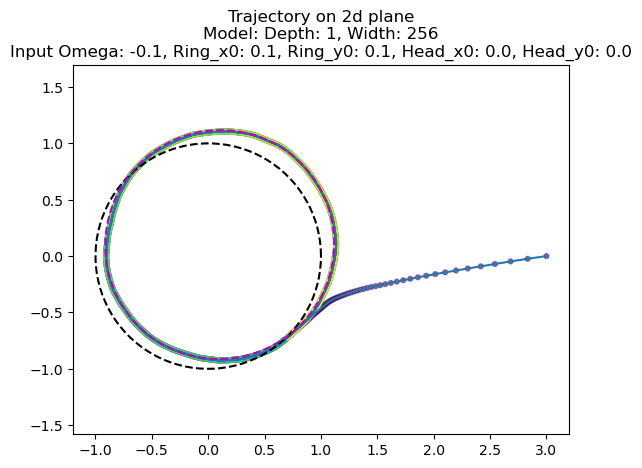

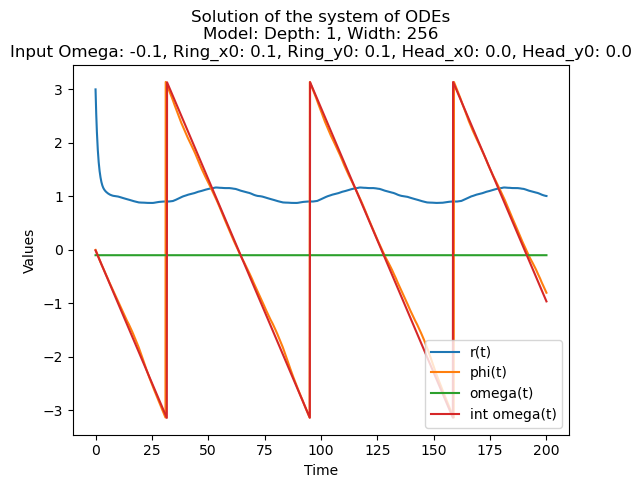

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sigma_v = 0.1
# solve the ode with torch model
t_span = (0, 200)
t_eval = torch.linspace(*t_span, 2000)
R0 = 1.0
omega0 = -0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
y0 = torch.tensor([3.0, 0.0], dtype=torch.float32, device=device)
sol = solve_neural_ode(model, ctrl_inps, y0, t_eval).cpu()
expstr = f'Model: Depth: {n_depth}, Width: {n_width}\nInput Omega: {omega0}, Ring_x0: {ring_x0}, Ring_y0: {ring_y0}, Head_x0: {H_x0}, Head_y0: {H_y0}'

plot_x_trajectory(sol, t_eval, expstr, R0, ring_x0, ring_y0)
plot_solution_curve(sol, t_eval, ctrl_inps, expstr, sigma_v=sigma_v)

$$dx/dt=-x + W_1W_2\phi(x)+Bu$$

torch.Size([128, 7]) torch.Size([2, 128])


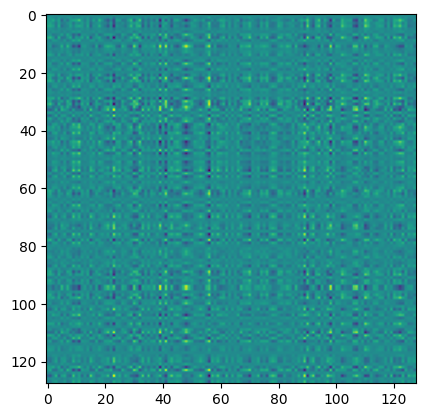

In [53]:
W1 = model[0].weight.detach().cpu()
b1 = model[0].bias.detach().cpu()
W2 = model[-1].weight.detach().cpu()
b2 = model[-1].bias.detach().cpu()
print(W1.shape, W2.shape)
recur_weight = W1[:, :2] @ W2
input_weight = W1[:, 2:]
b_recur = b1 + W1[:, :2] @ b2

plt.figure()
plt.imshow(recur_weight)
plt.show()

RNN dynamics
$$\frac{dh}{dt}=-h+VU^{T}\phi(h)+(b_{1}+Vb_{2})+W(u+\frac{du}{dt})$$
$$\frac{dh}{dt}=-h+W_{recur}\phi(h)+b_{recur}+W_{inp}(u)$$ 


torch.Size([256, 7]) torch.Size([2, 256])


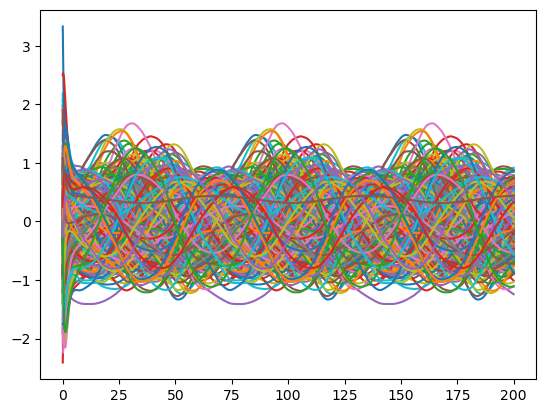

In [46]:
def run_rnn_euler(h_init, t_eval, recur_weight, input_weight, b_recur, ctrl_inps):
    h = h_init
    sol = []
    delta_t = t_eval[1] - t_eval[0]
    for t in t_eval:
        h = h + ( - h + recur_weight @ F.relu(h) + input_weight @ ctrl_inps(t) + b_recur) * delta_t
        sol.append(h)
    return torch.stack(sol, dim=0).cpu()

# Construct RNN weights and biases from the MLP model
W1 = model[0].weight.detach()#.cpu()
b1 = model[0].bias.detach()#.cpu()
W2 = model[-1].weight.detach()#.cpu()
b2 = model[-1].bias.detach()#.cpu()
print(W1.shape, W2.shape)
recur_weight = W1[:, :2] @ W2
input_weight = W1[:, 2:]
b_recur = b1 + W1[:, :2] @ b2

t_span = (0, 200)
t_eval = torch.linspace(*t_span, 2000)
R0 = 1.0
omega0 = 0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
x_init = torch.randn(n_width, device=device) 
sol = run_rnn_euler(x_init, t_eval, recur_weight, input_weight, b_recur, ctrl_inps)

plt.figure()
plt.plot(t_eval, sol)
plt.show()

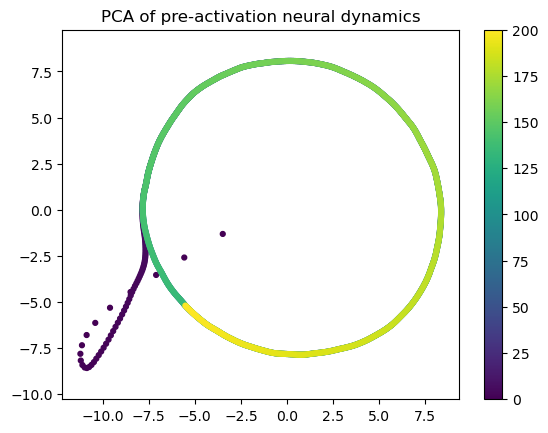

In [50]:
# plot PCA of neural dynamics
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
traj_proj = pca.fit_transform(sol)
plt.figure()
plt.scatter(traj_proj[:, 0], traj_proj[:, 1], c=t_eval, cmap='viridis', s=12)
plt.colorbar()
plt.axis('equal')
plt.title('PCA of pre-activation neural dynamics')
plt.show()

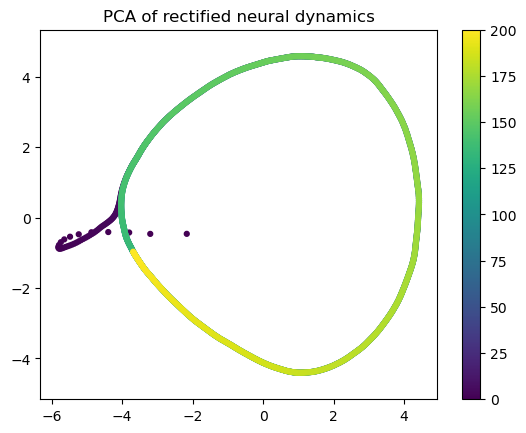

In [51]:
# plot PCA of neural dynamics
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
traj_proj = pca.fit_transform(F.relu(sol))
plt.figure()
plt.scatter(traj_proj[:, 0], traj_proj[:, 1], c=t_eval, cmap='viridis', s=12)
plt.colorbar()
plt.axis('equal')
plt.title('PCA of rectified neural dynamics')
plt.show()

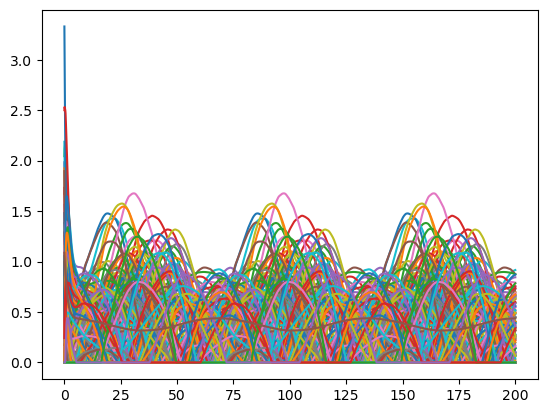

In [52]:
plt.figure()
plt.plot(t_eval, F.relu(sol))
plt.show()

(-2.5028984367847444,
 1.280113559961319,
 -2.8377116084098817,
 1.2987971663475038)

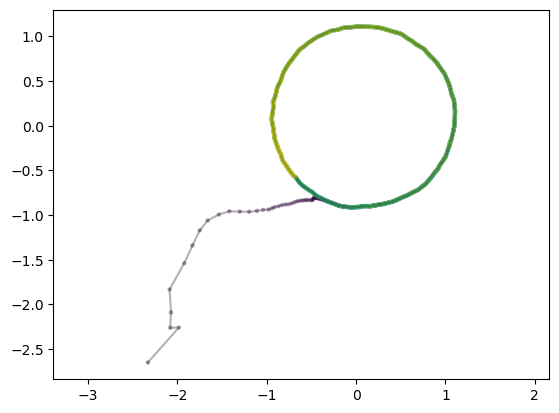

In [54]:
latent_traj = (F.relu(sol) @ W2.T.cpu())
plt.plot(latent_traj[:, 0], latent_traj[:, 1], alpha=0.3 , color="k")
plt.scatter(latent_traj[:, 0], latent_traj[:, 1],c=t_eval,s=5,alpha=0.3)
plt.axis("equal")

## Spiking neural network model of the recurrent dynamics

https://www.pnas.org/doi/10.1073/pnas.1905926116

https://github.com/rkim35/spikeRNN

In [55]:
if False:
    import numpy as np
    from scipy.io import loadmat
    def LIF_network_fnc(model_path, scaling_factor, u, stims, downsample, use_initial_weights):
        """
        Function to simulate a LIF (Leaky Integrate-and-Fire) network.

        Parameters:
        - model_path: Path to the trained model file (.mat).
        - scaling_factor: Scaling factor for transferring weights from rate to spk.
        - u: Input stimulus to be used (numpy array).
        - stims: Dictionary for artificial stimulations (to model optogenetic stim).
            - 'mode': "none", "exc" (depolarizing), or "inh" (hyperpolarizing).
            - 'dur': [stim_onset, stim_offset].
            - 'units': List containing unit indices to be stimulated.
        - downsample: Downsample factor (1 => no downsampling, 2 => every other sample, etc...).
        - use_initial_weights: Whether to use w0 (random initial weights). This is mainly used for testing.

        Returns:
        - W: Recurrent connectivity matrix scaled by the scaling factor (N x N).
        - REC: Membrane voltage from all the units (N x t).
        - spk: Binary matrix indicating spikes (N x t).
        - rs: Firing rates from all the units (N x t).
        - all_fr: Average firing rates from all the units (N x 1).
        - out: Network output (1 x t).
        - params: Dictionary containing sampling rate info and other parameters.
        """

        # Load variables from the model_path
        data = loadmat(model_path)
        w_in = data['w_in']
        w = data['w']
        w0 = data['w0']
        N = int(data['N'].squeeze())
        m = data['m']
        som_m = data['som_m']
        w_out = data['w_out']
        inh = data['inh'].squeeze()
        exc = data['exc'].squeeze()
        taus_gaus0 = data['taus_gaus0']
        taus_gaus = data['taus_gaus']
        taus = data['taus'].squeeze()

        # Shuffle nonzero weights
        if use_initial_weights:
            w = w0 * m * som_m
        else:
            w = w * m * som_m

        # Scale the connectivity weights by the optimal scaling factor
        W = w / scaling_factor

        # Inhibitory and excitatory neurons
        inh_ind = np.where(inh)[0]
        exc_ind = np.where(exc)[0]

        # Input stimulus
        u = u[:, ::downsample]
        ext_stim = w_in @ u

        # LIF network parameters
        dt = 0.00005 * downsample    # sampling rate
        T = (u.shape[1] - 1) * dt * 100  # trial duration (in sec)
        nt = int(round(T / dt))           # total number of points in a trial
        tref = 0.002               # refractory time constant (in sec)
        tm = 0.010                 # membrane time constant (in sec)
        vreset = -65               # voltage reset (in mV)
        vpeak = -40                # voltage peak (in mV) for linear LIF

        # Synaptic decay time constants (in sec) for the double-exponential synaptic filter
        # tr: rising time constant
        # td: decay time constants
        # td0: initial decay time constants (before optimization)
        if taus.size > 1:
            td = (1.0 / (1 + np.exp(-taus_gaus))) * (taus[1] - taus[0]) + taus[0]
            td = td * 5 / 1000
            td0 = (1.0 / (1 + np.exp(-taus_gaus0))) * (taus[1] - taus[0]) + taus[0]
            td0 = td0 * 5 / 1000
            tr = 0.002
        else:
            td = taus * 5 / 1000
            td0 = td
            tr = 0.002

        # Synaptic parameters
        IPSC = np.zeros(N)      # post synaptic current storage variable
        h = np.zeros(N)         # storage variable for filtered firing rates
        r = np.zeros(N)         # second storage variable for filtered rates
        hr = np.zeros(N)        # third variable for filtered rates
        JD = np.zeros(N)        # storage variable required for each spike time
        tspike = np.zeros((4 * nt, 2)) # storage variable for spike times
        ns = 0                  # number of spikes, counts during simulation

        v = vreset + np.random.rand(N) * (30 - vreset)  # initialize voltage with random distributions
        v_ = v.copy()   # v_ is the voltage at previous time steps
        v0 = v.copy()   # store the initial voltage values

        # Record REC (membrane voltage), Is (input currents),
        # spk (spike raster), rs (firing rates) from all the units
        REC = np.zeros((nt, N))  # membrane voltage (in mV) values
        Is = np.zeros((N, nt))  # input currents from the ext_stim
        IPSCs = np.zeros((N, nt)) # IPSC over time
        spk = np.zeros((N, nt)) # spikes
        rs = np.zeros((N, nt))  # firing rates
        hs = np.zeros((N, nt)) # filtered firing rates

        # used to set the refractory times
        tlast = np.zeros(N)

        # Constant bias current to be added to ensure the baseline membrane voltage
        # is around the rheobase
        BIAS = vpeak  # for linear LIF

        # Start the simulation
        for i in range(nt):
            # Record the IPSC over time
            IPSCs[:, i] = IPSC

            I = IPSC + BIAS  # synaptic current

            # Apply external input stim if there is any
            index = int(round(i / 100))
            if index < ext_stim.shape[1]:
                I += ext_stim[:, index]
                Is[:, i] = ext_stim[:, index]
            else:
                I += 0
                Is[:, i] = 0

            # LIF voltage equation with refractory period
            dv = ((dt * (i + 1) > tlast + tref).astype(float) * (-v + I) / tm)  # linear LIF
            v = v + dt * dv + np.random.randn(N) / 10

            # Artificial stimulation/inhibition
            if stims['mode'].lower() == 'exc':
                if stims['dur'][0] <= i < stims['dur'][1]:
                    rand_vals = np.random.rand(len(stims['units']))
                    v[stims['units'][rand_vals < 0.5]] += 0.5
            elif stims['mode'].lower() == 'inh':
                if stims['dur'][0] <= i < stims['dur'][1]:
                    rand_vals = np.random.rand(len(stims['units']))
                    v[stims['units'][rand_vals < 0.5]] -= 0.5

            # find the neurons that have fired
            index_spike = np.where(v >= vpeak)[0]

            # store spike times, and get the weight matrix column sum of spikers
            if len(index_spike) > 0:
                JD = np.sum(W[:, index_spike], axis=1)  # compute the increase in current due to spiking
                tspike[ns:ns + len(index_spike), :] = np.column_stack((index_spike, np.zeros(len(index_spike)) + dt * (i + 1)))
                ns += len(index_spike)
            else:
                JD = np.zeros(N)

            # used to set the refractory period of LIF neurons
            tlast = tlast + ((dt * (i + 1) - tlast) * (v >= vpeak))

            # if the rise time is 0, then use the single synaptic filter,
            # otherwise (i.e. rise time is positive) use the double filter
            if tr == 0:
                IPSC = IPSC * np.exp(-dt / td) + JD / td
                r = r * np.exp(-dt / td) + (v >= vpeak).astype(float) / td
                rs[:, i] = r
            else:
                IPSC = IPSC * np.exp(-dt / td) + h * dt
                h = h * np.exp(-dt / tr) + JD / (tr * td)
                hs[:, i] = h

                r = r * np.exp(-dt / td) + hr * dt
                hr = hr * np.exp(-dt / tr) + (v >= vpeak).astype(float) / (tr * td)
                rs[:, i] = r

            # record the spikes
            spk[:, i] = (v >= vpeak).astype(float)

            v = v + (30 - v) * (v >= vpeak)

            # record the membrane voltage tracings from all the units
            REC[i, :] = v

            # reset with spike time interpolant implemented
            v = v + (vreset - v) * (v >= vpeak)

        time = np.arange(1, nt + 1)

        # Compute the network output
        out = (w_out / scaling_factor) @ rs

        # Compute average firing rate for each population (excitatory/inhibitory)
        inh_fr = np.array([np.sum(spk[idx, :] > 0) / T for idx in inh_ind])
        exc_fr = np.array([np.sum(spk[idx, :] > 0) / T for idx in exc_ind])

        all_fr = np.array([np.sum(spk[i, 9:] > 0) / T for i in range(N)])

        REC = REC.T

        # Some params
        params = {
            'dt': dt,
            'T': T,
            'nt': nt,
            'w_out': w_out,
            'td': td,
            'td0': td0,
            'IPSCs': IPSCs
        }

        return W, REC, spk, rs, all_fr, out, params

In [56]:
import torch as th
from easydict import EasyDict as edict
def LIF_network_fnc_py(data, scaling_factor, u, downsample, ):
    # #FUNCTION LIF_network_fnc
    # #INPUT
    # #  - model_path: trained model full path (directory + filename)
    # #  - scaling_factor: scaling factor for transferring weights from rate to spk
    # #  - u: input stimulus to be used
    # #  - stims: struct for artificial stimulations (to model optogenetic stim)
    # #      - mode: "none", "exc" (depolarizing), or "inh" (hyperpolarizing)
    # #      - dur: [stim_onset stim_offset]
    # #      - units: vector containing unit indices to be stimulated
    # #  - downsample: downsample factor (1 => no downsampling, 2 => every other sample, etc...)
    # #                While downsample > 1 can speed up the conversion, the LIF network
    # #                might not be as robust as the one without downsampling
    # #  - use_initial_weights: whether to use w0 (random initial weights). This is mainly used
    # #                         for testing.
    # #
    # #OUTPUT
    # #  - W: recurrent connectivity matrix scaled by the scaling factor (N x N)
    # #  - REC: membrane voltage from all the units (N x t)
    # #  - spk: binary matrix indicating spikes (N x t)
    # #  - rs: firing rates from all the units (N x t)
    # #  - all_fr: average firing rates from all the units (N x 1)
    # #  - out: network output (1 x t)
    # #  - params: struct containing sampling rate info

    # #------------------------------------------------------
    # #Extract the number of units and the connectivity
    # #matrix from the trained continuous rate model
    # #------------------------------------------------------
    # load(model_path, 'w_in', 'w', 'w0', 'N', 'm', 'som_m', 'w_out', ...
    # 'inh', 'exc', 'taus_gaus0', 'taus_gaus', 'taus');
    w_in = data['w_in'];
    w = data['w'];
    b = data['bias'];
    # w0 = data['w0'];
    N = data['N'];
    # m = data['m'];
    # som_m = data['som_m'];
    w_out = data['w_out'];
    # inh = data['inh'];
    # exc = data['exc'];
    taus_gaus0 = data['taus_gaus0'];
    taus_gaus = data['taus_gaus'];
    taus = data['taus'];
    
    # Number of neurons and the trained connectivity weight
    # matrix (extracted from the trained continuous rate model)
    # N = double(N)

    #Shuffle nonzero weights #TODO: not sure what this is doing 
    # if use_initial_weights:
    #     w = w0 * m.*som_m
    # else:
    #     w = w * m.*som_m

    # Scale the connectivity weights by the optimal scaling factor 
    W = w/scaling_factor

    # Inhibitory and excitatory neurons
    # inh_ind = np.where(inh)[0]
    # exc_ind = np.where(exc)[0]

    # Input stimulus
    u = u[:, ::downsample]
    ext_stim = w_in @ u

    #------------------------------------------------------
    # LIF network parameters
    #------------------------------------------------------
    dt = 0.00005*downsample;    # sampling rate
    T = (u.shape[1] - 1) * dt * 100  # trial duration (in sec)
    nt = round(T/dt);           # total number of points in a trial
    tref = 0.002;               # refractory time constant (in sec)
    tm = 0.010;                 # membrane time constant (in sec)
    vreset = -65;               # voltage reset (in mV)
    vpeak = -40;                # voltage peak (in mV) for linear LIF
    #vpeak = 30;                # voltage peak (in mV) for quadratic LIF
    #rng(1);

    # Synaptic decay time constants (in sec) for the double-exponential
    # synpatic filter
    # tr: rising time constant
    # td: decay time constants
    # td0: initial decay time constants (before optimization)
    if len(taus) > 1:
        td = ( (1 / (1 + math.exp(-taus_gaus)) * (taus[1] - taus[0])) + taus[0] ) * 5 / 1000 
        td0 = ( (1 / (1 + math.exp(-taus_gaus0)) * (taus[1] - taus[0])) + taus[0] ) * 5 / 1000
        tr = 0.002
    else:
        td = taus * 5 / 1000 
        td0 = td
        tr = 0.002

    # Synaptic parameters
    IPSC = th.zeros(N,1)      # post synaptic current storage variable
    h = th.zeros(N,1)         # storage variable for filtered firing rates
    r = th.zeros(N,1)         # second storage variable for filtered rates
    hr = th.zeros(N,1)        # third variable for filtered rates
    JD = 0*IPSC               # storage variable required for each spike time
    tspike = th.zeros(4*nt,2) # storage variable for spike times
    ns = 0                    # number of spikes, counts during simulation

    v = vreset + th.rand(N,1)*(30-vreset); # initialize voltage with random distribtuions
    v_ = v;   # v_ is the voltage at previous time steps
    v0 = v;   # store the initial voltage values

    #Record REC (membrane voltage), Is (input currents), 
    #spk (spike raster), rs (firing rates) from all the units
    REC = th.zeros(N, nt);  #membrane voltage (in mV) values
    Is = th.zeros(N, nt);  #input currents from the ext_stim
    IPSCs = th.zeros(N, nt); #IPSC over time
    spk = th.zeros(N, nt); #spikes
    rs = th.zeros(N, nt);  #firing rates
    hs = th.zeros(N, nt); #filtered firing rates

    #used to set the refractory times
    tlast = th.zeros(N,1); 

    #Constant bias current to be added to ensure the baseline membrane voltage
    #is around the rheobase
    BIAS = vpeak; #for linear LIF
    #BIAS = 0;    #for quadratic LIF
    I_bias = b # bias current for each unit
    #------------------------------------------------------
    #Start the simulation
    #------------------------------------------------------
    for i in range(nt):
        IPSCs[:, i] = IPSC #record the IPSC over time (comment out if not used to save time)

        I = IPSC + BIAS + I_bias; #synaptic current

        #Apply external input stim if there is any
        I_ext = ext_stim[:, i] #ext_stim(:, round(i/100)+1);
        I = I + I_ext
        Is[:, i] = I_ext

        #LIF voltage equation with refractory period
        # dv = (dt*i>tlast + tref).*(-v+I)/tm; #linear LIF
        # dv = (dt*i>tlast + tref).*(v.^2+I)/tm; #quadratic LIF
        # v = v + dt*(dv) + randn(N, 1)/10;
        dv = ((dt * i > tlast + tref).astype(float) * (-v + I) / tm) # linear LIF # use i
        v = v + dt * dv + th.randn(N) / 10

        #find the neurons that have fired
        index_spike = np.where(v >= vpeak)[0]

        #store spike times, and get the weight matrix column sum of spikers
        if len(index_spike) > 0:
            JD = W[:, index_spike].sum(dim=1); #compute the increase in current due to spiking
            # tspike[ns:ns+len(index_spike),:] = [index_spike, [0*index+dt*i]];
            tspike[ns:ns+len(index_spike), 0] = index_spike
            tspike[ns:ns+len(index_spike), 1] = dt * i  # TODO: check if this is i or i+1
            ns += len(index_spike)  #total number of psikes so far
        else:
            JD = th.zeros(N, 1)

        #used to set the refractory period of LIF neurons
        tlast = tlast + (dt*i - tlast) * (v>=vpeak) # TODO: check i or i+1? 

        #if the rise time is 0, then use the single synaptic filter,
        #otherwise (i.e. rise time is positive) use the double filter
        if tr == 0:
            IPSC = IPSC * math.exp(-dt / td) + JD / td # *(len(index_spike) > 0)
            r = r * math.exp(-dt / td) + (v >= vpeak).astype(float) / td
            rs[:, i] = r
        else:
            IPSC = IPSC * math.exp(- dt / td) + h * dt
            h = h * math.exp(-dt/tr) + JD / (tr*td) # *(len(index_spike) > 0)  #Integrate the current
            hs[:, i] = h

            r = r * math.exp(-dt / td) + hr * dt
            hr = hr * math.exp(-dt / tr) + (v >= vpeak).astype(float) / (tr * td)
            rs[:, i] = r

        #record the spikes
        spk[:, i] = v >= vpeak
        
        v = v + (30 - v) * (v>=vpeak)

        #record the membrane voltage tracings from all the units
        REC[:, i] = v; 

        #reset with spike time interpolant implemented.
        v = v + (vreset - v) * (v>=vpeak); 

    time = th.arange(1, nt + 1)

    #Plot the population response
    out = w_out/scaling_factor*rs

    #Compute average firing rate for each population (excitatory/inhibitory)
    # inh_fr = th.zeros(size(inh_ind));
    # for i = 1:length(inh_ind):
    #     inh_fr(i) = length(find(spk(inh_ind(i), :)>0))/T;

    # exc_fr = th.zeros(size(exc_ind));
    # for i = 1:length(exc_ind):
    #     exc_fr(i) = length(find(spk(exc_ind(i), :)>0))/T;

    # all_fr = th.zeros(size(exc));
    # for i = 1:N
    #     all_fr(i) = length(find(spk(i, 10:end)>0))/T;


    #Some params
    # Some params
    params = edict({
        'dt': dt,
        'T': T,
        'nt': nt,
        'w_out': w_out,
        'td': td,
        'td0': td0,
        'IPSCs': IPSCs
    })
    return W, REC, spk, rs, out, params # all_fr, 

In [276]:
import torch as th
from easydict import EasyDict as edict
def LIF_network_fnc_py_simple(data, u_func, scaling_factor, downsample=1, Tmax=1.0, 
                              v_noise=True, device='cpu'):
    # #FUNCTION LIF_network_fnc
    # #INPUT
    # #  - model_path: trained model full path (directory + filename)
    # #  - scaling_factor: scaling factor for transferring weights from rate to spk
    # #  - u: input stimulus to be used
    # #  - stims: struct for artificial stimulations (to model optogenetic stim)
    # #      - mode: "none", "exc" (depolarizing), or "inh" (hyperpolarizing)
    # #      - dur: [stim_onset stim_offset]
    # #      - units: vector containing unit indices to be stimulated
    # #  - downsample: downsample factor (1 => no downsampling, 2 => every other sample, etc...)
    # #                While downsample > 1 can speed up the conversion, the LIF network
    # #                might not be as robust as the one without downsampling
    # #  - use_initial_weights: whether to use w0 (random initial weights). This is mainly used
    # #                         for testing.
    # #
    # #OUTPUT
    # #  - W: recurrent connectivity matrix scaled by the scaling factor (N x N)
    # #  - REC: membrane voltage from all the units (N x t)
    # #  - spk: binary matrix indicating spikes (N x t)
    # #  - rs: firing rates from all the units (N x t)
    # #  - all_fr: average firing rates from all the units (N x 1)
    # #  - out: network output (1 x t)
    # #  - params: struct containing sampling rate info

    # #------------------------------------------------------
    # #Extract the number of units and the connectivity
    # #matrix from the trained continuous rate model
    # #------------------------------------------------------
    # load(model_path, 'w_in', 'w', 'w0', 'N', 'm', 'som_m', 'w_out', ...
    # 'inh', 'exc', 'taus_gaus0', 'taus_gaus', 'taus');
    
    w = data['w'];
    w_in = data['w_in'];
    w_out = data['w_out'];
    b = data['bias'];
    # w0 = data['w0'];
    N = data['N'];
    # m = data['m'];
    # som_m = data['som_m'];
    taus_gaus0 = data['taus_gaus0'];
    taus_gaus = data['taus_gaus'];
    taus = data['taus'];
    
    # Number of neurons and the trained connectivity weight
    # matrix (extracted from the trained continuous rate model)
    # N = double(N)

    # Scale the connectivity weights by the optimal scaling factor 
    W = w / scaling_factor
    I_bias = b  # bias current for each unit no need for scaling???/ scaling_factor

    # # Input stimulus
    # u = u[:, ::downsample]
    # ext_stim = w_in @ u

    #------------------------------------------------------
    # LIF network parameters
    #------------------------------------------------------
    dt = 0.00005 * downsample;    # sampling rate
    T = Tmax #(u.shape[1] - 1) * dt * 100  # trial duration (in sec)
    nt = round(T/dt);           # total number of points in a trial
    tref = 0.002;               # refractory time constant (in sec)
    tm = 0.010;                 # membrane time constant (in sec)
    vreset = -65;               # voltage reset (in mV)
    vpeak = -40;                # voltage peak (in mV) for linear LIF
    #vpeak = 30;                # voltage peak (in mV) for quadratic LIF
    #rng(1);

    # Synaptic decay time constants (in sec) for the double-exponential
    # synpatic filter
    # tr: rising time constant
    # td: decay time constants
    # td0: initial decay time constants (before optimization)
    if len(taus) > 1:
        td = ( (1 / (1 + th.exp(-taus_gaus)) * (taus[1] - taus[0])) + taus[0] ) * 5 / 1000 
        td0 = ( (1 / (1 + th.exp(-taus_gaus0)) * (taus[1] - taus[0])) + taus[0] ) * 5 / 1000
        tr = th.tensor(0.002, device=device)
    else:
        td = taus * 5 / 1000 
        td0 = td
        tr = th.tensor(0.002, device=device)

    # Synaptic parameters
    IPSC = th.zeros(N, device=device)      # post synaptic current storage variable
    h = th.zeros(N, device=device)         # storage variable for filtered firing rates
    r = th.zeros(N, device=device)         # second storage variable for filtered rates
    hr = th.zeros(N, device=device)        # third variable for filtered rates
    JD = th.zeros(N, device=device)               # storage variable required for each spike time
    # tspike = th.zeros(4*nt,2) # storage variable for spike times
    tspike = [[], []]
    ns = 0                    # number of spikes, counts during simulation

    v = vreset + th.rand(N, device=device)*(30-vreset); # initialize voltage with random distribtuions
    v_ = v;   # v_ is the voltage at previous time steps
    v0 = v;   # store the initial voltage values

    #Record REC (membrane voltage), Is (input currents), 
    #spk (spike raster), rs (firing rates) from all the units
    REC = th.zeros(N, nt, device=device);  #membrane voltage (in mV) values
    Is = th.zeros(N, nt, device=device);  #input currents from the ext_stim
    IPSCs = th.zeros(N, nt, device=device); #IPSC over time
    spk = th.zeros(N, nt, device=device); #spikes
    rs = th.zeros(N, nt, device=device);  #firing rates
    hs = th.zeros(N, nt, device=device); #filtered firing rates

    #used to set the refractory times
    tlast = th.zeros(N, device=device); 

    #Constant bias current to be added to ensure the baseline membrane voltage
    #is around the rheobase
    BIAS = vpeak; #for linear LIF
    #BIAS = 0;    #for quadratic LIF
    #------------------------------------------------------
    #Start the simulation
    #------------------------------------------------------
    for i in range(nt):
        IPSCs[:, i] = IPSC #record the IPSC over time (comment out if not used to save time)

        I = IPSC + BIAS + I_bias; #synaptic current
        ext_stim = w_in @ u_func(i * dt)
        #Apply external input stim if there is any
        I_ext = ext_stim #ext_stim(:, round(i/100)+1);
        I = I + I_ext
        Is[:, i] = I_ext

        #LIF voltage equation with refractory period
        # dv = (dt*i>tlast + tref).*(-v+I)/tm; #linear LIF
        # dv = (dt*i>tlast + tref).*(v.^2+I)/tm; #quadratic LIF
        # v = v + dt*(dv) + randn(N, 1)/10;
        dv = ((dt * i > (tlast + tref) ).to(float) * (-v + I) / tm) # linear LIF # use i
        v = (v + dt * dv + th.randn(N, device=device) / 10) if v_noise else v + dt * dv

        #find the neurons that have fired
        index_spike = th.where(v >= vpeak)[0]

        #store spike times, and get the weight matrix column sum of spikers
        if len(index_spike) > 0:
            JD = W[:, index_spike].sum(dim=1); #compute the increase in current due to spiking
            # tspike[ns:ns+len(index_spike),:] = [index_spike, [0*index+dt*i]];
            # tspike[ns:ns+len(index_spike), 0] = index_spike
            # tspike[ns:ns+len(index_spike), 1] = dt * i  # TODO: check if this is i or i+1
            ns += len(index_spike)  #total number of psikes so far
            tspike[0].extend(index_spike.cpu())
            tspike[1].extend([dt * i] * len(index_spike))
        else:
            JD = th.zeros(N, device=device)

        #used to set the refractory period of LIF neurons
        tlast = tlast + (dt * i - tlast) * (v>=vpeak) # TODO: check i or i+1? 

        #if the rise time is 0, then use the single synaptic filter,
        #otherwise (i.e. rise time is positive) use the double filter
        if tr == 0:
            IPSC = IPSC * th.exp(-dt / td) + JD / td # *(len(index_spike) > 0)
            r = r * th.exp(-dt / td) + (v >= vpeak).to(float) / td
            rs[:, i] = r
        else:
            IPSC = IPSC * th.exp(- dt / td) + h * dt
            h = h * th.exp(-dt/tr) + JD / (tr*td) # *(len(index_spike) > 0)  #Integrate the current
            hs[:, i] = h

            r = r * th.exp(-dt / td) + hr * dt
            hr = hr * th.exp(-dt / tr) + (v >= vpeak).to(float) / (tr * td)
            rs[:, i] = r

        #record the spikes
        spk[:, i] = v >= vpeak
        v = v + (30 - v) * (v>=vpeak)

        #record the membrane voltage tracings from all the units
        REC[:, i] = v; 

        #reset with spike time interpolant implemented.
        v = v + (vreset - v) * (v>=vpeak) 

    # time = th.arange(1, nt + 1)

    #Plot the population response
    out = w_out @ rs / scaling_factor
    spike_rate = spk.sum(dim=1) / T
    print("mean spike rate", spike_rate.mean().item(),
        "std", spike_rate.std().item(),)
    #Some params
    # Some params
    params = edict({
        'dt': dt,
        'T': T,
        'nt': nt,
        'w_out': w_out,
        'td': td,
        'td0': td0,
        'IPSCs': IPSCs
    })
    return W, REC, spk, rs, out, params # all_fr, 

In [259]:
def MLP2lowrankRNN_parameter(model, device='cpu'):
    W1 = model[0].weight.detach().to(device)
    b1 = model[0].bias.detach().to(device)
    W2 = model[-1].weight.detach().to(device)
    b2 = model[-1].bias.detach().to(device)
    recur_weight = W1[:, :2] @ W2
    input_weight = W1[:, 2:]
    b_recur = b1 + W1[:, :2] @ b2
    output_weight = W2
    return recur_weight, input_weight, output_weight, b_recur

### Train Softplus model

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.4985693097114563
epoch 1000, loss: 0.006069808267056942
epoch 2000, loss: 0.0019999886862933636
epoch 3000, loss: 0.0012427631299942732
epoch 4000, loss: 0.0009275294141843915
epoch 5000, loss: 0.0007455939776264131
epoch 6000, loss: 0.0006656404584646225
epoch 7000, loss: 0.0005584993632510304
epoch 8000, loss: 0.0005161968292668462
epoch 9000, loss: 0.00047410998377017677
epoch 9999, loss: 0.0004387892549857497


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


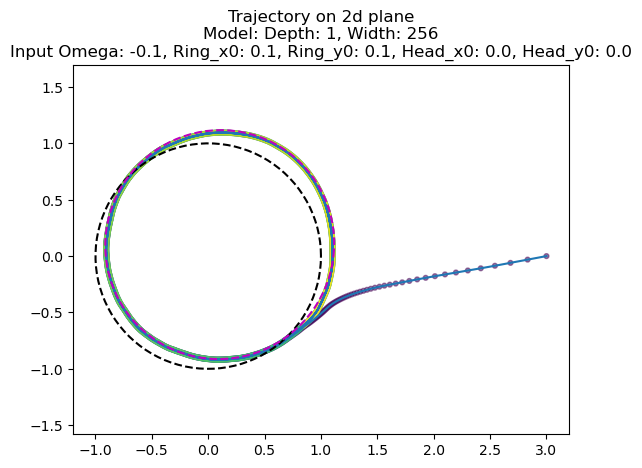

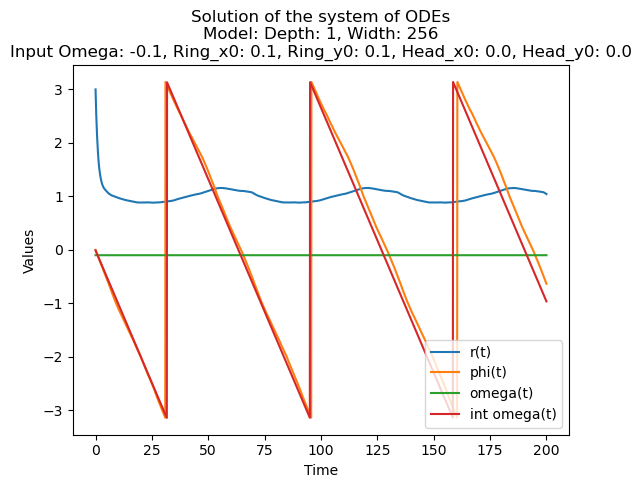

In [272]:
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, 
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
n_depth, n_width = 1, 256
model = build_MLP(n_width, n_depth, activation=nn.Softplus)
model = train_MLP(dataset, model=model, n_depth=n_depth, n_width=n_width, 
          lr=1e-3, n_epochs=10000, print_every=1000)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sigma_v = 0.1
# solve the ode with torch model
t_span = (0, 200)
t_eval = torch.linspace(*t_span, 2000)
R0 = 1.0
omega0 = -0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
y0 = torch.tensor([3.0, 0.0], dtype=torch.float32, device=device)
sol = solve_neural_ode(model, ctrl_inps, y0, t_eval).cpu()
expstr = f'Model: Depth: {n_depth}, Width: {n_width}\nInput Omega: {omega0}, Ring_x0: {ring_x0}, Ring_y0: {ring_y0}, Head_x0: {H_x0}, Head_y0: {H_y0}'

plot_x_trajectory(sol, t_eval, expstr, R0, ring_x0, ring_y0)
plot_solution_curve(sol, t_eval, ctrl_inps, expstr, sigma_v=sigma_v)

mean spike rate 19.2734375 std 9.251825332641602


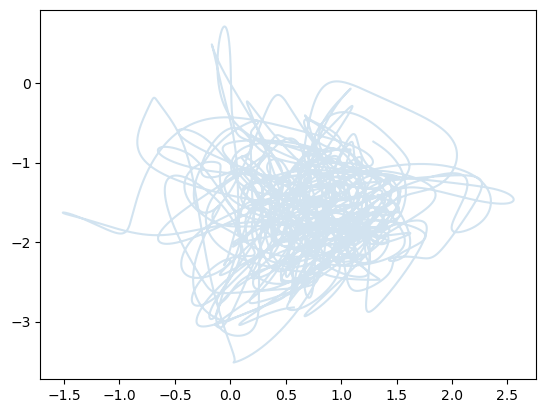

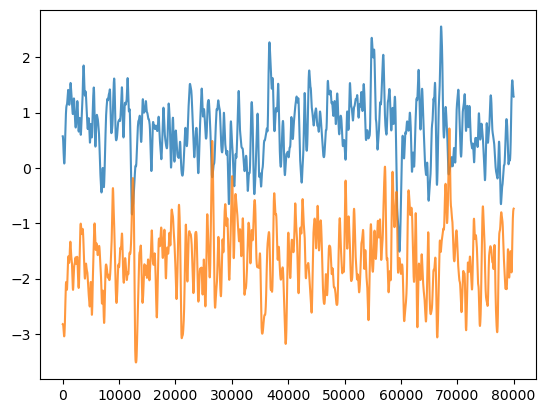

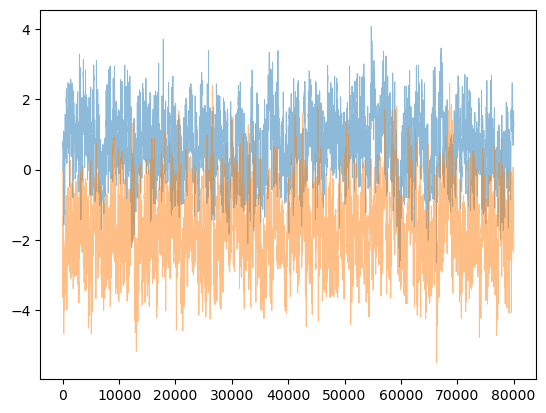

In [275]:
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
recur_weight, input_weight, output_weight, b_recur = MLP2lowrankRNN_parameter(model, device=device)
N = recur_weight.shape[0]
R0 = 1.0
omega0 = 0.05
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
data = {}
data['w'] = recur_weight.to(device)
data['w_in'] = input_weight.to(device)
data['bias'] = b_recur.to(device)
data['w_out'] = output_weight.to(device)
data['N'] = recur_weight.shape[0]
data['taus_gaus0'] = th.randn(N, device=device) # 10 #0.005
data['taus_gaus'] = th.randn(N, device=device) # 10 #0.005
# data['taus'] = th.tensor([4.0, 20.0], dtype=th.float32)
data['taus'] = th.tensor([4.0, 20.0], dtype=th.float32, device=device)
W_snn, REC, spk, rs, out_snn, params = LIF_network_fnc_py_simple(data, ctrl_inps, 
                            scaling_factor=25.0, downsample=5, Tmax=20.0, v_noise=True,
                            device=device)

# convolutional smoothing of the output
from scipy.ndimage import gaussian_filter1d
out_snn_smooth = gaussian_filter1d(out_snn.cpu().numpy(), 100, axis=-1)

plt.plot(out_snn_smooth[0], out_snn_smooth[1], alpha=0.2)
plt.show()

plt.plot(out_snn_smooth[0], alpha=0.8)
plt.plot(out_snn_smooth[1], alpha=0.8)
plt.show()

plt.plot(out_snn.T, lw=0.7, alpha=0.5)
plt.show()

mean spike rate 15.394140243530273 std 11.116347312927246


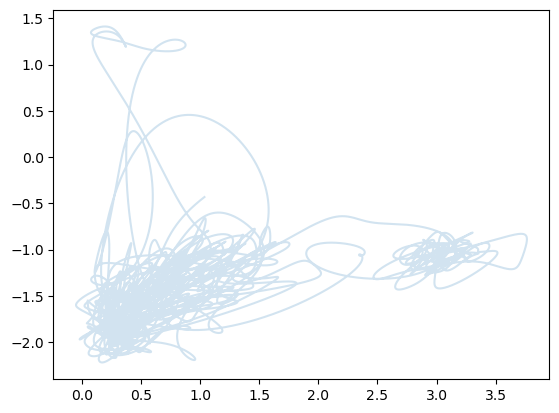

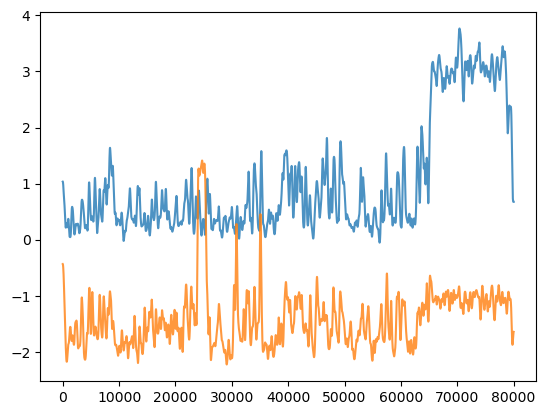

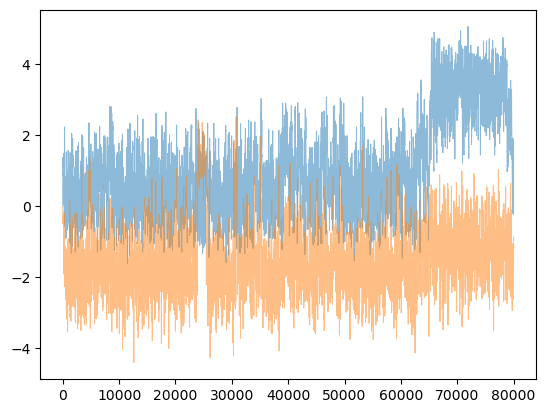

In [278]:
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
recur_weight, input_weight, output_weight, b_recur = MLP2lowrankRNN_parameter(model, device=device)
N = recur_weight.shape[0]
R0 = 1.0
omega0 = 0.05
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
data = {}
data['w'] = recur_weight.to(device)
data['w_in'] = input_weight.to(device)
data['bias'] = b_recur.to(device)
data['w_out'] = output_weight.to(device)
data['N'] = recur_weight.shape[0]
data['taus_gaus0'] = th.randn(N, device=device) # 10 #0.005
data['taus_gaus'] = th.randn(N, device=device) # 10 #0.005
# data['taus'] = th.tensor([4.0, 20.0], dtype=th.float32)
data['taus'] = th.tensor([4.0, 20.0], dtype=th.float32, device=device)
W_snn, REC, spk, rs, out_snn, params = LIF_network_fnc_py_simple(data, ctrl_inps, 
                            scaling_factor=25.0, downsample=5, Tmax=20.0, v_noise=False,
                            device=device)

# convolutional smoothing of the output
from scipy.ndimage import gaussian_filter1d
out_snn_smooth = gaussian_filter1d(out_snn.cpu().numpy(), 100, axis=-1)

plt.plot(out_snn_smooth[0], out_snn_smooth[1], alpha=0.2)
plt.show()

plt.plot(out_snn_smooth[0], alpha=0.8)
plt.plot(out_snn_smooth[1], alpha=0.8)
plt.show()

plt.plot(out_snn.T, lw=0.7, alpha=0.5)
plt.show()

### Train Sigmoid model 

In [ ]:
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, 
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
n_depth, n_width = 1, 512
model = build_MLP(n_width, n_depth, activation=nn.Sigmoid)
model = train_MLP(dataset, model=model, n_depth=n_depth, n_width=n_width, 
          lr=1e-3, n_epochs=10000, print_every=1000)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sigma_v = 0.1
# solve the ode with torch model
t_span = (0, 200)
t_eval = torch.linspace(*t_span, 2000)
R0 = 1.0
omega0 = -0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
y0 = torch.tensor([3.0, 0.0], dtype=torch.float32, device=device)
sol = solve_neural_ode(model, ctrl_inps, y0, t_eval).cpu()
expstr = f'Model: Depth: {n_depth}, Width: {n_width}\nInput Omega: {omega0}, Ring_x0: {ring_x0}, Ring_y0: {ring_y0}, Head_x0: {H_x0}, Head_y0: {H_y0}'

plot_x_trajectory(sol, t_eval, expstr, R0, ring_x0, ring_y0)
plot_solution_curve(sol, t_eval, ctrl_inps, expstr, sigma_v=sigma_v)

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.5544233322143555
epoch 1000, loss: 0.003512402530759573
epoch 2000, loss: 0.001382890623062849
epoch 3000, loss: 0.0008754414157010615
epoch 4000, loss: 0.0006474543479271233
epoch 5000, loss: 0.0005203838809393346
epoch 6000, loss: 0.0004377234436105937
epoch 7000, loss: 0.0005064973956905305
epoch 8000, loss: 0.00034856778802350163
epoch 9000, loss: 0.000317270663799718
epoch 9999, loss: 0.00029945772257633507


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


In [260]:
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
recur_weight, input_weight, output_weight, b_recur = MLP2lowrankRNN_parameter(model, device=device)
N = recur_weight.shape[0]
R0 = 1.0
omega0 = 0.05
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
data = {}
data['w'] = recur_weight.to(device)
data['w_in'] = input_weight.to(device)
data['bias'] = b_recur.to(device)
data['w_out'] = output_weight.to(device)
data['N'] = recur_weight.shape[0]
data['taus_gaus0'] = th.randn(N, device=device) # 10 #0.005
data['taus_gaus'] = th.randn(N, device=device) # 10 #0.005
# data['taus'] = th.tensor([4.0, 20.0], dtype=th.float32)
data['taus'] = th.tensor([4.0, 20.0], dtype=th.float32, device=device)
W_snn, REC, spk, rs, out_snn, params = LIF_network_fnc_py_simple(data, ctrl_inps, 
                            scaling_factor=10.0, downsample=10, Tmax=20.0, device=device)
# convolutional smoothing of the output
from scipy.ndimage import gaussian_filter1d
out_snn_smooth = gaussian_filter1d(out_snn.cpu().numpy(), 100, axis=-1)
plt.plot(out_snn_smooth[0], out_snn_smooth[1], alpha=0.2)
plt.show()
plt.plot(out_snn_smooth[0], alpha=0.8)
plt.plot(out_snn_smooth[1], alpha=0.8)
plt.show()
plt.plot(out_snn.T, lw=0.7, alpha=0.5)
plt.show()

mean spike rate 27.332616806030273 std 29.62082290649414


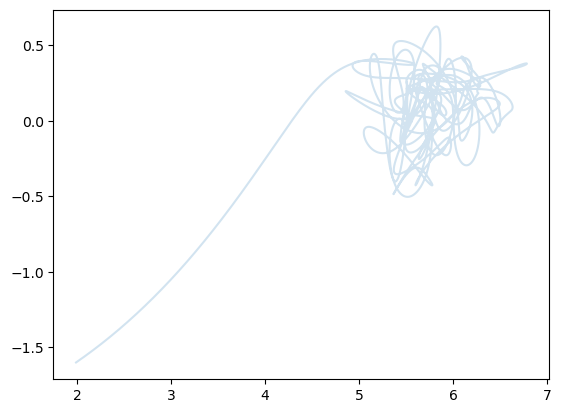

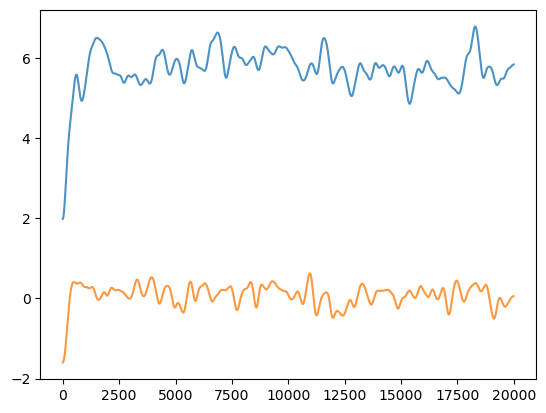

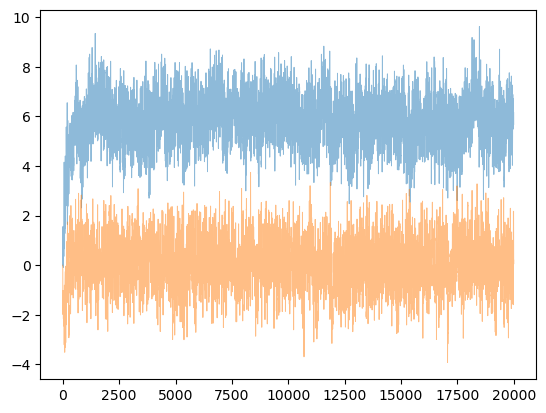

In [254]:
# convolutional smoothing of the output
from scipy.ndimage import gaussian_filter1d
out_snn_smooth = gaussian_filter1d(out_snn.cpu().numpy(), 100, axis=-1)
plt.plot(out_snn_smooth[0], out_snn_smooth[1], alpha=0.2)
plt.show()
plt.plot(out_snn_smooth[0], alpha=0.8)
plt.plot(out_snn_smooth[1], alpha=0.8)
plt.show()
plt.plot(out_snn.T, lw=0.7, alpha=0.5)
plt.show()

### Debugging spikes

In [243]:
spk.shape

torch.Size([256, 50000])

In [244]:
b_recur

tensor([ 0.0270,  0.0423, -0.5301, -0.0177, -0.0173, -0.0417,  0.0827,  0.0585,
         0.0514,  0.0152,  0.0515, -0.3654, -0.0944,  0.1314,  0.0342,  0.5033,
        -0.3149,  0.0969, -0.3070, -0.0953, -0.4928, -0.0429,  0.0124, -0.0118,
        -0.6517,  0.0551, -0.0024,  0.0735,  0.3953,  0.1012,  0.0187,  0.0209,
         0.0655, -0.3660, -0.0088, -0.0728, -0.0253,  0.0241, -0.0582, -0.0629,
        -0.5156,  0.1767,  0.0811, -0.3667,  0.0023, -0.0298, -0.5167,  0.6596,
        -0.4657,  0.0718,  0.2211,  0.0771,  0.3345, -0.2830,  0.2611, -0.0938,
        -0.4257, -0.0593,  0.0239, -0.0167, -0.1402,  0.0673, -0.2783, -0.1811,
         0.0301, -0.0535,  0.0691, -0.0273, -0.2071,  0.0239, -0.0150, -0.0587,
         0.0984,  0.0224,  0.0598, -0.1362,  0.2650,  0.3961, -0.2249,  0.0381,
         0.0187, -0.4206,  0.2669,  0.0250,  0.0745,  0.0517, -0.4239,  0.0192,
        -0.0117,  0.3840,  0.0598, -0.1055, -0.0652, -0.0701,  0.1211,  0.0636,
         0.0582,  0.0185, -0.1360,  0.04

In [245]:
current = 0
for ti in range(150, 300):
    current += recur_weight[:, spk[:, ti].bool()].sum(dim=1)
current

tensor([-0.4541, -0.6429, -0.0458,  0.4493, -0.2446,  0.6171,  0.0083, -0.4932,
        -0.1514, -0.1218, -0.1707, -0.3369, -0.4169,  0.2075, -0.6927,  0.2244,
        -0.1480,  0.6998,  0.1100, -0.5763, -0.1473, -0.4656,  0.0286,  0.2379,
        -0.1202, -0.0801, -0.0322,  0.3916,  0.1093,  0.7070,  0.2256, -0.4182,
        -0.5420,  0.0118, -0.2635,  0.0031,  0.4808,  0.2560, -0.6351,  0.3537,
        -0.1777,  0.1608,  0.5730,  0.2491, -0.0529,  0.5758, -0.1857, -0.0946,
        -0.1571, -0.5680, -0.1737,  0.7566, -0.0019,  0.0236, -0.2172, -0.7105,
         0.3514, -0.1651,  0.2618, -0.1968,  0.0948,  0.2391, -0.2275, -0.0132,
         0.3341,  0.1680, -0.1955, -0.3680,  0.0545, -0.4951,  0.2807,  0.3839,
         0.5027,  0.1485,  0.4406, -0.2606, -0.0379, -0.1152, -0.1428, -0.5171,
        -0.3472,  0.1429, -0.2931, -0.1980, -0.1143,  0.4803,  0.1539, -0.3493,
         0.0728,  0.2408,  0.4041, -0.3363,  0.6469, -0.7298,  0.2780,  0.0923,
        -0.3320, -0.0085,  0.0331, -0.36

### ReLU model

In [ ]:
recur_weight, input_weight, output_weight, b_recur = MLP2lowrankRNN_parameter(model, device=device)

R0 = 1.0
omega0 = 0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)

t_span = (0, 200)
t_eval = torch.linspace(*t_span, 2000)

In [ ]:
recur_weight, input_weight, output_weight, b_recur = \
    MLP2lowrankRNN_parameter(model, device=device)

device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
R0 = 1.0
omega0 = 0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
data = {}
data['w'] = recur_weight.to(device)
data['w_in'] = input_weight.to(device)
data['bias'] = b_recur.to(device)
data['w_out'] = W2.to(device)
data['N'] = recur_weight.shape[0]
data['taus_gaus0'] = 0.005 #th.randn() ##0.005
data['taus_gaus'] = 0.005#th.randn()  #0.005
# data['taus'] = th.tensor([4.0, 20.0], dtype=th.float32)
data['taus'] = th.tensor([20.0], dtype=th.float32, device=device)
W_snn, REC, spk, rs, out_snn, params = LIF_network_fnc_py_simple(data, ctrl_inps, 
                                            scaling_factor=20.0, downsample=4, Tmax=10.0, device=device)

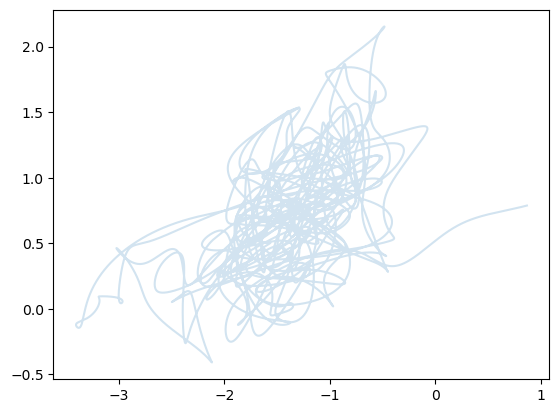

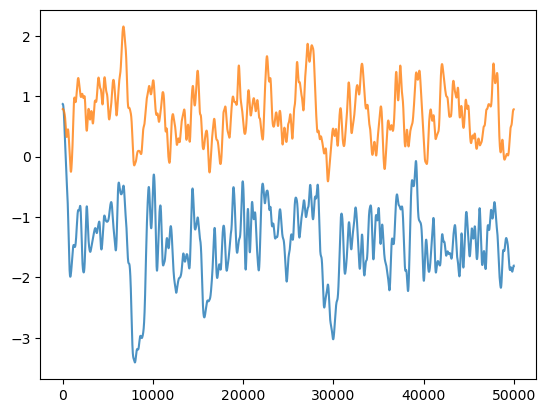

In [ ]:
# convolutional smoothing of the output
from scipy.ndimage import gaussian_filter1d
out_snn_smooth = gaussian_filter1d(out_snn.cpu().numpy(), 100, axis=-1)

plt.plot(out_snn_smooth[0], out_snn_smooth[1], alpha=0.2)
plt.show()
plt.plot(out_snn_smooth[0], alpha=0.8)
plt.plot(out_snn_smooth[1], alpha=0.8)
plt.show()

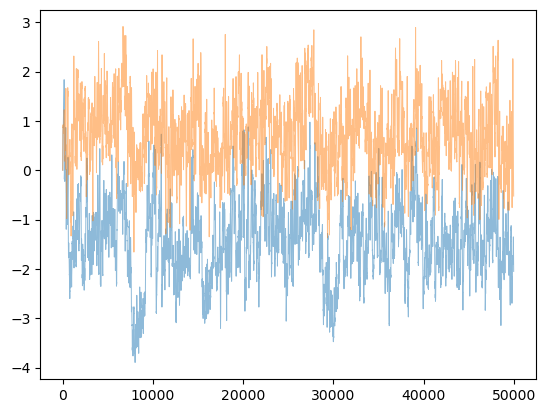

In [ ]:
plt.plot(out_snn.T, lw=0.7, alpha=0.5)
plt.show()

In [ ]:
out_snn.shape

torch.Size([2, 50000])

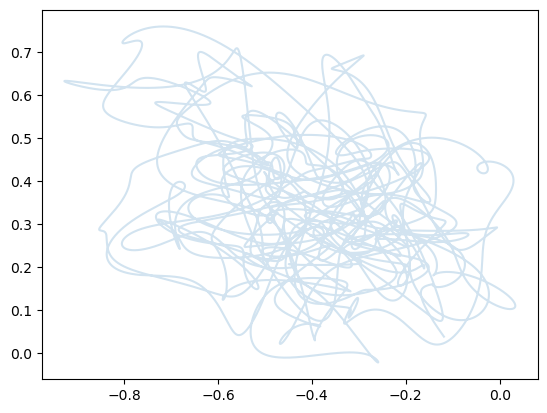

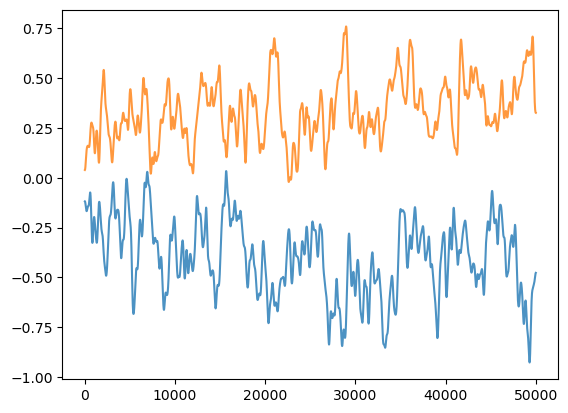

In [ ]:
# convolutional smoothing of the output
from scipy.ndimage import gaussian_filter1d
out_snn_smooth = gaussian_filter1d(out_snn.cpu().numpy(), 100, axis=-1)

plt.plot(out_snn_smooth[0], out_snn_smooth[1], alpha=0.2)
plt.show()
plt.plot(out_snn_smooth[0], alpha=0.8)
plt.plot(out_snn_smooth[1], alpha=0.8)
plt.show()

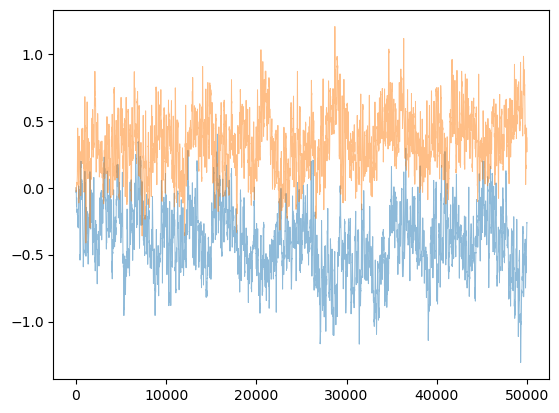

In [ ]:
plt.plot(out_snn.T, lw=0.7, alpha=0.5)
plt.show()

#### Scratch

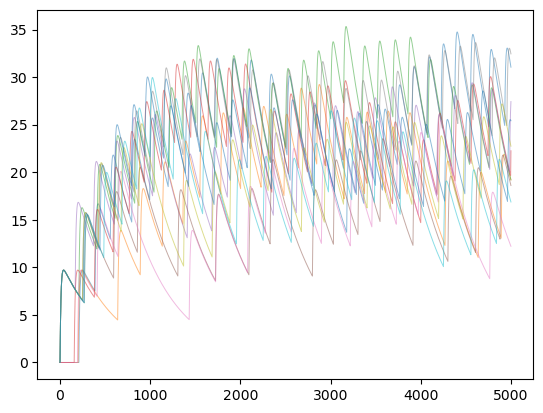

In [198]:
plt.plot(rs.T[:5000, ::25], lw=0.7, alpha=0.5);

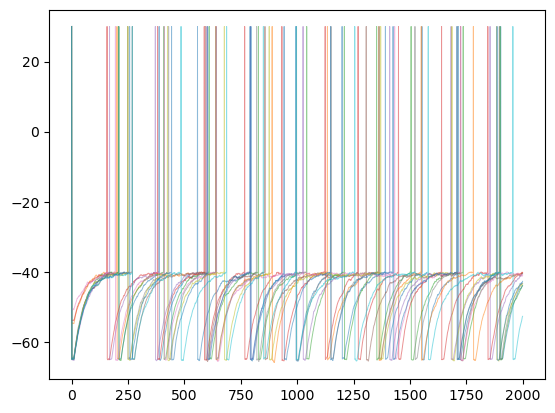

In [199]:
plt.plot(REC.T[:2000, ::25], lw=0.7, alpha=0.5);

### Even simpler: Random feature model

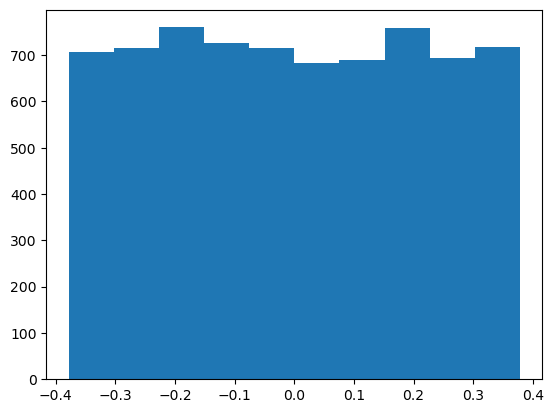

In [72]:
# demo a random feature model
model = build_randfeature_MLP(1024, 1)
plt.hist(model[0].weight.flatten())
plt.show()

In [73]:
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, 
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
n_depth, n_width = 1, 512
model = build_randfeature_MLP(n_width, n_depth)
model = train_MLP(dataset, model=model, 
          lr=1e-3, n_epochs=10000, print_every=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.3148600459098816
epoch 1000, loss: 0.016918912529945374
epoch 2000, loss: 0.011145304888486862
epoch 3000, loss: 0.00903699453920126
epoch 4000, loss: 0.007921972312033176
epoch 5000, loss: 0.0072768391110002995
epoch 6000, loss: 0.0068935202434659
epoch 7000, loss: 0.0066358898766338825
epoch 8000, loss: 0.006476412992924452
epoch 9000, loss: 0.0063675991259515285
epoch 9999, loss: 0.006359944585710764


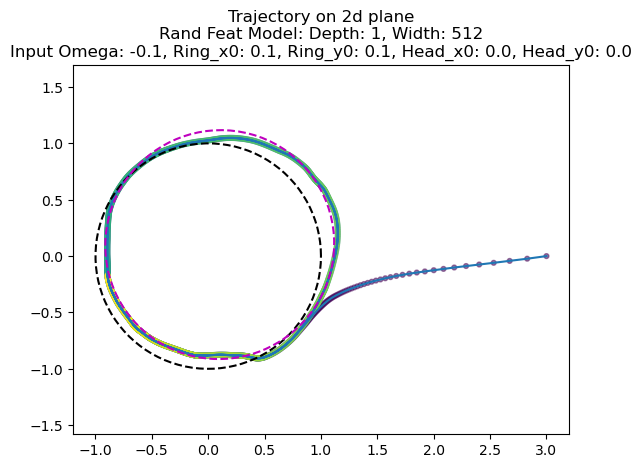

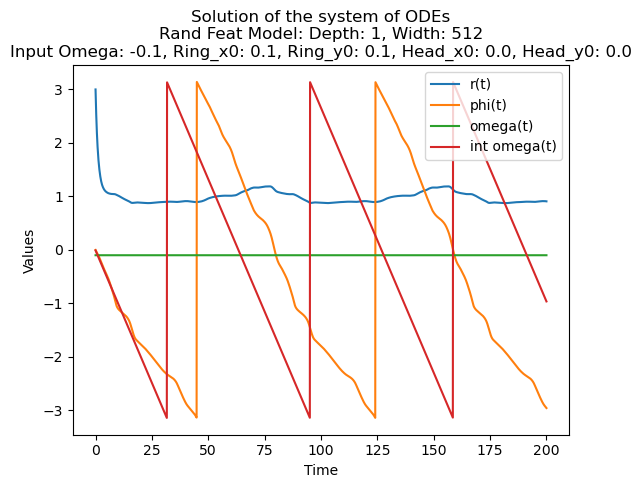

In [79]:
t_span = (0, 200)
t_eval = torch.linspace(*t_span, 2000)
omega0 = -0.1
ring_x0, ring_y0 = 0.1, 0.1
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
y0 = torch.tensor([3, 0.0], dtype=torch.float32, device=device)
sol = solve_neural_ode(model, ctrl_inps, y0, t_eval).cpu()
expstr = f'Rand Feat Model: Depth: {n_depth}, Width: {n_width}\nInput Omega: {omega0}, Ring_x0: {ring_x0}, Ring_y0: {ring_y0}, Head_x0: {H_x0}, Head_y0: {H_y0}'

plot_x_trajectory(sol, t_eval, expstr, R0, ring_x0, ring_y0)
plot_solution_curve(sol, t_eval, ctrl_inps, expstr, sigma_v=sigma_v)

## Original scratch space

In [44]:
# optimize model
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1,
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
# make a torch dataset of these, and train a MLP to predict dx, dy
n_depth, n_width = 1, 128
model = build_MLP(n_width, n_depth)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = F.mse_loss
n_epochs = 10000
# use full batch update 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_batch, y_batch = dataset.tensors
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)
model.to(device)
model.train()
pbar = tqdm(range(n_epochs))
for epoch in pbar:    
    optimizer.zero_grad()
    y_pred = model(x_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    pbar.set_postfix({'loss': loss.item()})
    if epoch #500 == 0 or (epoch == 0):
        print(f'epoch {epoch}, loss: {loss.item()}')

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.30651557445526123
epoch 500, loss: 0.014743396081030369
epoch 1000, loss: 0.008406534790992737
epoch 1500, loss: 0.005289338529109955
epoch 2000, loss: 0.003122317837551236
epoch 2500, loss: 0.0021198010072112083
epoch 3000, loss: 0.0016969096614047885
epoch 3500, loss: 0.0014606248587369919
epoch 4000, loss: 0.0013027603272348642
epoch 4500, loss: 0.0011887840228155255
epoch 5000, loss: 0.0011005940614268184
epoch 5500, loss: 0.0010335535043850541
epoch 6000, loss: 0.0009702313109301031
epoch 6500, loss: 0.0009314821218140423
epoch 7000, loss: 0.0008776712347753346
epoch 7500, loss: 0.0008455488132312894
epoch 8000, loss: 0.0008145690662786365
epoch 8500, loss: 0.0007953739259392023
epoch 9000, loss: 0.0007750624790787697
epoch 9500, loss: 0.0007688460755161941


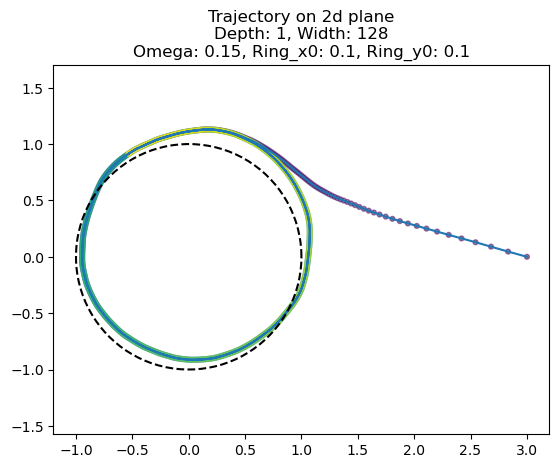

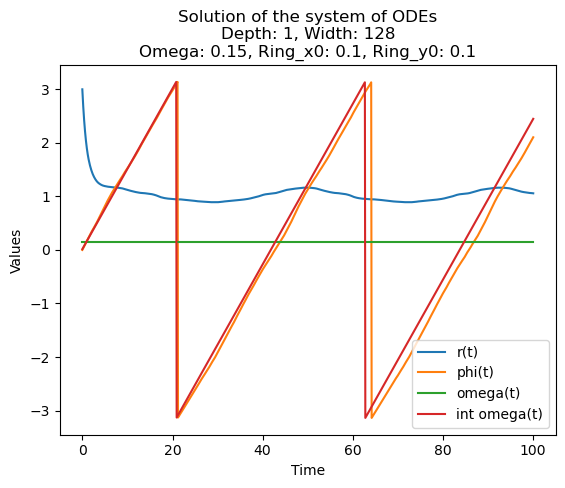

In [ ]:
x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy = construct_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1)

dataset = TensorDataset(torch.tensor(np.stack([x, y, omega, x0, y0, Hx, Hy], axis=1), dtype=torch.float32),
                        torch.tensor(np.stack([target_dx, target_dy], axis=1), dtype=torch.float32))
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
n_width = 128
n_depth = 1
layers = []
layers.append(nn.Linear(7, n_width))
layers.append(nn.ReLU())
for i in range(n_depth-1):
    layers.append(nn.Linear(n_width, n_width))
    layers.append(nn.ReLU())
layers.append(nn.Linear(n_width, 2))
model = nn.Sequential(*layers)

### Full analytical model

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [ ]:
# Define the function for the system of ODEs
def system_euclid_odes(t, state, R0, phi0, sigma_v, sigma_h, h, psi0, theta0, omega, eps):
    # Unpack variables
    x, y, = state
    r = np.sqrt(x**2 + y**2)
    psi = np.arctan2(y, x)
    # Compute parameters
    alpha = 1 / (1 + sigma_v**2)
    beta = h / (sigma_h**2 * (sigma_v**-2 + 1))
    # R function
    R_psi = R0 + r * eps * np.cos(psi - phi0)
    # Define the ODEs
    dx_dt = -x + R_psi * np.cos(psi) - alpha * y * omega(t) + beta * np.cos(psi0(t) - theta0)
    dx_dot_dt = -y + R_psi * np.sin(psi) + alpha * x * omega(t) + beta * np.sin(psi0(t) - theta0)    
    return [dx_dt, dx_dot_dt]


# Define the function for the system of ODEs
def system_of_odes(t, y, R0, phi0, sigma_v, sigma_h, h, psi0, theta0, omega):
    # Unpack variables
    x, x_dot, r, psi = y
    # Compute parameters
    alpha = 1 / (1 + sigma_v**2)
    beta = h / (sigma_h**2 * (sigma_v**-2 + 1))
    # R function
    R_psi = R0 + r * np.cos(psi - phi0)
    # Define the ODEs
    dx_dt = -x + R_psi * np.cos(psi) - alpha * x_dot * omega(t) + beta * np.cos(psi0(t) - theta0)
    dx_dot_dt = -x_dot + R_psi * np.sin(psi) + alpha * x * omega(t) + beta * np.sin(psi0(t) - theta0)
    
    dr_dt = -r + R_psi + beta * np.cos(psi0(t) - theta0 - psi)
    dpsi_dt = alpha * omega(t) + (beta / r) * np.sin(psi0(t) - theta0 - psi)
    
    return [dx_dt, dx_dot_dt, dr_dt, dpsi_dt]


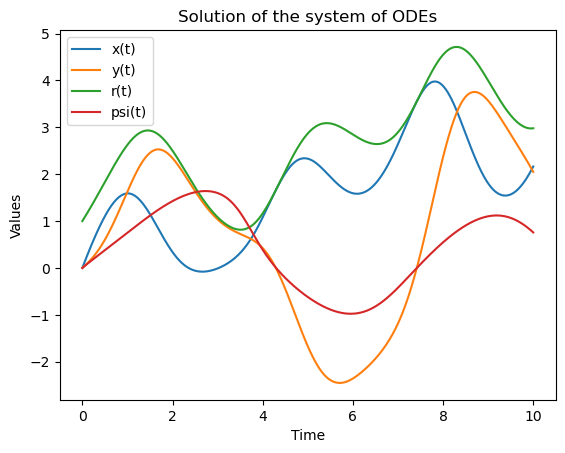

In [ ]:

# Example of omega(t) and psi0(t)
def omega(t):
    return np.sin(t)  # Example function for omega

def psi0(t):
    return np.cos(t)  # Example function for psi0

# Initial conditions
y0 = [0.0, 0.0, 1.0, 0.0]  # Initial values for x, x_dot, r, psi

# Time span
t_span = (0, 10)  # From t=0 to t=10
t_eval = np.linspace(0, 10, 1000)  # Points at which to store the solution

# Parameters
R0 = 1.0
phi0 = 0.0
sigma_v = 0.1
sigma_h = 0.1
h = 1.0
theta0 = 0.0

# Solve the system of ODEs
sol = solve_ivp(system_of_odes, t_span, y0, t_eval=t_eval, args=(R0, phi0, sigma_v, sigma_h, h, psi0, theta0, omega))

# Plot the solution
plt.figure()
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.plot(sol.t, sol.y[1], label='y(t)')
plt.plot(sol.t, sol.y[2], label='r(t)')
plt.plot(sol.t, sol.y[3], label='psi(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Solution of the system of ODEs')
plt.show()

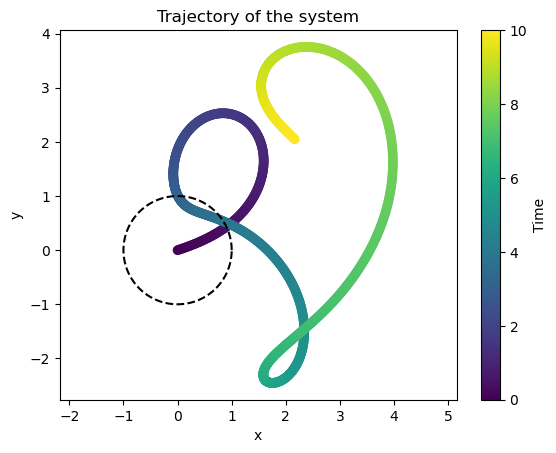

In [ ]:

# Plot the solution
plt.figure()
# plot x, y on the 2d plane, colored by sol.t
plt.scatter(sol.y[0], sol.y[1], c=sol.t)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the system')
plt.colorbar(label='Time')
# plot the unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--')
plt.axis('equal')
plt.show()

# plt.plot(sol.t, sol.y[0], label='x(t)')
# plt.plot(sol.t, sol.y[1], label='y(t)')
# plt.plot(sol.t, sol.y[2], label='r(t)')
# plt.plot(sol.t, sol.y[3], label='psi(t)')
# plt.xlabel('Time')
# plt.ylabel('Values')
# plt.legend()
# plt.title('Solution of the system of ODEs')
# plt.show()

In [ ]:
t_span = (0, 100)  # From t=0 to t=10
t_eval = np.linspace(0, 100, 1000)  # Points at which to store the solution

# Speed, angular velocity, and head direction input signals
omega_fun = lambda t: -0.1
h_fun = lambda t: max(0, 0.1 * (1.5 + np.cos(0.1 * t)))
psi0_fun = lambda t: np.pi/2 + 0.1 * t #-0.2* t  # Example function for psi0
# Manifold Parameters
R0 = 1.0
eps = 0.25
phi0 = - np.pi/2
# Relative confidance in velocity and head direction signal, gating term of input. 
sigma_v = 0.1
sigma_h = 0.1
# h = 0.5
theta0 = 0.0 # this one is useless, can be combined into psi0
# Initial conditions
y0 = [3.0, 0.0,]  # Initial values for x, x_dot, r, psi

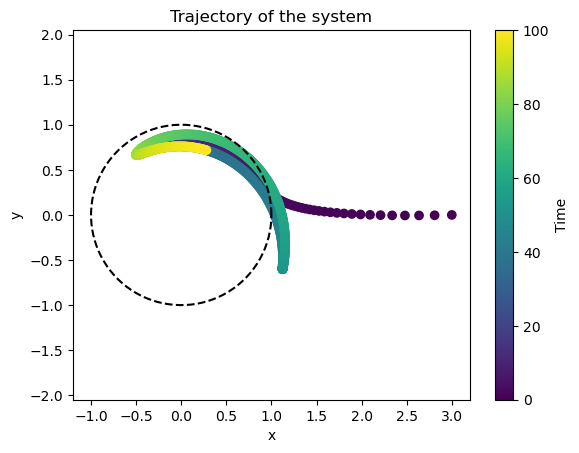

In [ ]:

# Plot the solution
plt.figure()
# plot x, y on the 2d plane, colored by sol.t
plt.scatter(sol.y[0], sol.y[1], c=sol.t)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the system')
plt.colorbar(label='Time')
# plot the unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--')
plt.axis('equal')
plt.show()

# plt.plot(sol.t, sol.y[0], label='x(t)')
# plt.plot(sol.t, sol.y[1], label='y(t)')
# plt.plot(sol.t, sol.y[2], label='r(t)')
# plt.plot(sol.t, sol.y[3], label='psi(t)')
# plt.xlabel('Time')
# plt.ylabel('Values')
# plt.legend()
# plt.title('Solution of the system of ODEs')
# plt.show()